# Proje Konusu ve Açıklama

Bir bankanın CRM biriminde kredi risk data scientist olarak çalışmaya başladım, bu sebeple bir kredi risk modelleme çalışması yapmak istedim. 

Kaggle üzerinde hackathon yapılmış bir datayı incelemeye karar verdim.

https://www.kaggle.com/c/fridayhackswithrba/data

Verileri kullanarak PD (Probability of Default - Kredinin geri ödenmeme ihtimali) hesaplaması yapmaya çalışacağım. 

Not: Bazı fonksiyonlar için uyarılar verdi ama iş yerinde de benzer şekilde kullandığım için değiştirmedim, aşağıda yerlerini yeniden belirteceğim.

Not2: Train ve test üzerinde veri hazırlığı yaptıktan sonra verileri csv olarak kaydettim, iş yerinde de yeniden hazırlık aşamasını çalıştırmadan modelde denemeler yapmak için böyle yapıyoruz. Modeli ayrı bir notebook üzerinde rahatça yapabilmek için de faydalı oluyor. Ben de modeli farklı bir notebook üzerinde yazacağım

## Gerekli kütüphaneler

Bu alanda proje içinde kullanmam gereken tüm kütüphaneleri ekleyeceğim. Sırası geldikçe import cümleciklerini burada çağıracağım, projenin genelinde kütüphane import ettiğim başka alan olmayacak.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## PD Model (Probability of Default)
Öncelikle PD modeli oluşturmak için dataset içindeki kolonların analizini yaptım. Hangi değişkenleri bağımsız değişkenler olarak almalıyım, inceledim. PD, müşterinin krediyi geri ödeyememe olasığı olduğu için logistic regresyon ile modelleyeceğim. Değişkenleri de sürekli nümerik olarak değil, kategorik olarak ele almalıyım ki logistic regresyon modelimi kurabileyim.

Verinin preprocess aşamasında kolonların türlerini ve kategorik olarak nasıl sınıflayabileceğimi kontrol edeceğim.

In [2]:
ls #dosyanın adını görmek için

IpekGamzeUcal_3Donem_Proje.ipynb   Train sete uyguladıklarım.ipynb
LCDataDictionary.xlsx              loan_data_2007_2014.csv


In [3]:
loan_data= pd.read_csv('loan_data_2007_2014.csv')

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (20) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#dosyayı okurken farklı veri tipleri olduğunda bu hata/uyarı gelebiliyor, low_memory=False dediğimde düzeldi
loan_data= pd.read_csv('loan_data_2007_2014.csv', low_memory=False)

## Verinin İncelenmesi

Kolonların anlamları LCDataDictionary.xlsx dosyasında yer alıyor.

In [5]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
pd.options.display.max_columns = None #tüm kolonları görebilmek için bu ayarı yaptım

In [7]:
loan_data.head()

,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,0,1077501,1296599,5000,5000,4975.0,36 months,10.65,162.87,B,B2,NaN,10+ years,RENT,24000.0,Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0.0,Jan-85,1.0,NaN,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,5000.00,861.07,0.00,0.00,0.00,Jan-15,171.62,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1077430,1314167,2500,2500,2500.0,60 months,15.27,59.83,C,C4,Ryder,< 1 year,RENT,30000.0,Source Verified,Dec-11,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0.0,Apr-99,5.0,NaN,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1077175,1313524,2400,2400,2400.0,36 months,15.96,84.33,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,small_business,real estate business,606xx,IL,8.72,0.0,Nov-01,2.0,NaN,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,2400.00,603.65,0.00,0.00,0.00,Jun-14,649.91,NaN,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1076863,1277178,10000,10000,10000.0,36 months,13.49,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,49200.0,Source Verified,Dec-11,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0.0,Feb-96,1.0,35.0,NaN,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,10000.00,2209.33,16.97,0.00,0.00,Jan-15,357.48,NaN,Jan-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1075358,1311748,3000,3000,3000.0,60 months,12.69,67.79,B,B5,University Medical Group,1 year,RENT,80000.0,Source Verified,Dec-11,Current,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 12/21/11 > I plan on combi...,other,Personal,972xx,OR,17.94,0.0,Jan-96,0.0,38.0,NaN,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,2233.10,1009.07,0.00,0.00,0.00,Jan-16,67.79,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
loan_data.columns #kolonların isimleri

Index(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'issue_d', 'loan_status', 'pymnt_plan', 'url',
       'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'verificatio

In [9]:
loan_data.info() #verilerin sayısını ve kolon türlerini görmek için

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 75 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   466285 non-null  int64  
 1   id                           466285 non-null  int64  
 2   member_id                    466285 non-null  int64  
 3   loan_amnt                    466285 non-null  int64  
 4   funded_amnt                  466285 non-null  int64  
 5   funded_amnt_inv              466285 non-null  float64
 6   term                         466285 non-null  object 
 7   int_rate                     466285 non-null  float64
 8   installment                  466285 non-null  float64
 9   grade                        466285 non-null  object 
 10  sub_grade                    466285 non-null  object 
 11  emp_title                    438697 non-null  object 
 12  emp_length                   445277 non-null  object 
 13 

### Kategorik veriler elde edebilmek için gruplanmış olan verilerin bazılarını anlaşılır hale getirmek gerekiyor

#### TERM

In [10]:
loan_data['term'].unique() #term verisini 36 ve 60 olarak yeni bir kolonda takip edeceğim

array([' 36 months', ' 60 months'], dtype=object)

In [11]:
loan_data['term_int']=loan_data['term'].str.replace(' 36 months','36')
loan_data['term_int']=loan_data['term_int'].str.replace(' 60 months','60')

In [12]:
type(loan_data['term_int'][0]) #string olan veriyi de int hale getireceğim

str

In [13]:
loan_data['term_int'] = pd.to_numeric(loan_data['term_int'])
# Transforms the values to numeric.

In [14]:
type(loan_data['term_int'][0]) #int64 hale geldi.

numpy.int64

In [15]:
loan_data['term_int']

0         36
1         60
2         36
3         36
4         60
          ..
466280    60
466281    60
466282    60
466283    36
466284    36
Name: term_int, Length: 466285, dtype: int64

#### EMP LENGTH

In [16]:
loan_data['emp_length'].unique() #years ifadelerini çıkarıp int yapacağım

array(['10+ years', '< 1 year', '1 year', '3 years', '8 years', '9 years',
       '4 years', '5 years', '6 years', '2 years', '7 years', nan],
      dtype=object)

In [17]:
loan_data['emp_length_int'] = loan_data['emp_length'].str.replace('\+ years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('< 1 year', str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace('n/a',  str(0))
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' years', '')
loan_data['emp_length_int'] = loan_data['emp_length_int'].str.replace(' year', '')

In [18]:
type(loan_data['emp_length_int'][0])

str

In [19]:
loan_data['emp_length_int'] = pd.to_numeric(loan_data['emp_length_int'])

In [20]:
type(loan_data['emp_length_int'][0])

numpy.float64

In [21]:
loan_data['emp_length_int']

0         10.0
1          0.0
2         10.0
3         10.0
4          1.0
          ... 
466280     4.0
466281    10.0
466282     7.0
466283     3.0
466284    10.0
Name: emp_length_int, Length: 466285, dtype: float64

#### earliest_cr_line ve issue_d tarih değişkenleri

In [22]:
loan_data['earliest_cr_line'] #dtype object

0         Jan-85
1         Apr-99
2         Nov-01
3         Feb-96
4         Jan-96
           ...  
466280    Apr-03
466281    Jun-97
466282    Dec-01
466283    Feb-03
466284    Feb-00
Name: earliest_cr_line, Length: 466285, dtype: object

In [23]:
loan_data['earliest_cr_line_date'] = pd.to_datetime(loan_data['earliest_cr_line'], format = '%b-%y')

In [24]:
type(loan_data['earliest_cr_line_date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [25]:
pd.to_datetime('2020-12-01') - loan_data['earliest_cr_line_date']

0        13118 days
1         7915 days
2         6970 days
3         9070 days
4         9101 days
            ...    
466280    6454 days
466281    8584 days
466282    6940 days
466283    6513 days
466284    7609 days
Name: earliest_cr_line_date, Length: 466285, dtype: timedelta64[ns]

In [26]:
#kredi ödeme tarihinden bu güne kadar geçen ayları buldum
loan_data['mths_since_earliest_cr_line'] = round(pd.to_numeric((pd.to_datetime('2020-12-01') - loan_data['earliest_cr_line_date']) / np.timedelta64(1, 'M')))

In [27]:
loan_data['mths_since_earliest_cr_line'].describe() 
#negatif ayları tespit ettiğimde biraz geç olmuştu ama yeniden dönüp negatifleri temizliyorum

count    466256.000000
mean        275.482430
std          93.974829
min        -576.000000
25%         219.000000
50%         261.000000
75%         321.000000
max         623.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [28]:
#negatifleri filtreleyince ileri tarihler oldupunu gördüm, yılın son 2 hanesine göre çevirince bu hale gelmişler
loan_data.loc[: , ['earliest_cr_line', 'earliest_cr_line_date', 'mths_since_earliest_cr_line']][loan_data['mths_since_earliest_cr_line'] < 0]

,earliest_cr_line,earliest_cr_line_date,mths_since_earliest_cr_line
1580,Sep-62,2062-09-01,-501.0
1770,Sep-68,2068-09-01,-573.0
2799,Sep-64,2064-09-01,-525.0
3282,Sep-67,2067-09-01,-561.0
3359,Feb-65,2065-02-01,-530.0
...,...,...,...
464003,Jan-68,2068-01-01,-565.0
464260,Jul-66,2066-07-01,-547.0
465100,Oct-67,2067-10-01,-562.0
465500,Sep-67,2067-09-01,-561.0


In [29]:
#negatif olanları maksimum tarihe kadar getirdim, çünkü bu negatif olanlar zaten 1960'lardan kalmaydı ve sayıları da çok azdı
loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()

<ipython-input-29-f6e0faa27083>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loan_data['mths_since_earliest_cr_line'][loan_data['mths_since_earliest_cr_line'] < 0] = loan_data['mths_since_earliest_cr_line'].max()


In [30]:
#bir uyarı verdi ama yine de çevirmiş, çünkü negatif kalmadı. Bu uyarıyı gideremedim.
loan_data['mths_since_earliest_cr_line'].describe() 

count    466256.000000
mean        278.385374
std          86.460310
min         109.000000
25%         220.000000
50%         262.000000
75%         321.000000
max         623.000000
Name: mths_since_earliest_cr_line, dtype: float64

In [31]:
loan_data['issue_d']

0         Dec-11
1         Dec-11
2         Dec-11
3         Dec-11
4         Dec-11
           ...  
466280    Jan-14
466281    Jan-14
466282    Jan-14
466283    Jan-14
466284    Jan-14
Name: issue_d, Length: 466285, dtype: object

In [32]:
#aynı işlemleri issue date için de yaptım, bu alanda negatifler olmadı.
loan_data['issue_d_date'] = pd.to_datetime(loan_data['issue_d'], format = '%b-%y')
loan_data['mths_since_issue_d'] = round(pd.to_numeric((pd.to_datetime('2020-12-01') - loan_data['issue_d_date']) / np.timedelta64(1, 'M')))
loan_data['mths_since_issue_d'].describe()

count    466285.000000
mean         87.255187
std          14.340154
min          72.000000
25%          77.000000
50%          83.000000
75%          93.000000
max         162.000000
Name: mths_since_issue_d, dtype: float64

### Yeniden dataya bakıyorum

In [33]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   Unnamed: 0                   466285 non-null  int64         
 1   id                           466285 non-null  int64         
 2   member_id                    466285 non-null  int64         
 3   loan_amnt                    466285 non-null  int64         
 4   funded_amnt                  466285 non-null  int64         
 5   funded_amnt_inv              466285 non-null  float64       
 6   term                         466285 non-null  object        
 7   int_rate                     466285 non-null  float64       
 8   installment                  466285 non-null  float64       
 9   grade                        466285 non-null  object        
 10  sub_grade                    466285 non-null  object        
 11  emp_title                 

### Continuous olmayan bazı değişkenler için de dummy değişkenler yaratmak gerekiyor: 

grade, sub_grade, home_ownership, verification_status, loan_status, purpose, addr_state, initial_list_status

In [34]:
loan_data['grade'].unique()

array(['B', 'C', 'A', 'E', 'F', 'D', 'G'], dtype=object)

In [35]:
loan_data['sub_grade'].unique()

array(['B2', 'C4', 'C5', 'C1', 'B5', 'A4', 'E1', 'F2', 'C3', 'B1', 'D1',
       'A1', 'B3', 'B4', 'C2', 'D2', 'A3', 'A5', 'D5', 'A2', 'E4', 'D3',
       'D4', 'F3', 'E3', 'F4', 'F1', 'E5', 'G4', 'E2', 'G3', 'G2', 'G1',
       'F5', 'G5'], dtype=object)

In [36]:
#değerin kendisine 1, kalanlara 0 yazdığı şekilde dummy değişkenler oluşturuyorum
pd.get_dummies(loan_data['grade'])

,A,B,C,D,E,F,G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
466280,0,0,1,0,0,0,0
466281,0,0,0,1,0,0,0
466282,0,0,0,1,0,0,0
466283,1,0,0,0,0,0,0


In [37]:
#dummy kolon isimlerine göre bir çok değişkeni ayırınca kolon isimleri çok karıştı :) 
#O yüzden kolon isimlerini değiştirerek dummy yarattım
pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':')

,grade:A,grade:B,grade:C,grade:D,grade:E,grade:F,grade:G
0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...
466280,0,0,1,0,0,0,0
466281,0,0,0,1,0,0,0
466282,0,0,0,1,0,0,0
466283,1,0,0,0,0,0,0


In [38]:
#tüm dummyleri bir df yapıp , kendi df'ime ekliyorum
loan_data_dummies = [pd.get_dummies(loan_data['grade'], prefix = 'grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['sub_grade'], prefix = 'sub_grade', prefix_sep = ':'),
                     pd.get_dummies(loan_data['home_ownership'], prefix = 'home_ownership', prefix_sep = ':'),
                     pd.get_dummies(loan_data['verification_status'], prefix = 'verification_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['loan_status'], prefix = 'loan_status', prefix_sep = ':'),
                     pd.get_dummies(loan_data['purpose'], prefix = 'purpose', prefix_sep = ':'),
                     pd.get_dummies(loan_data['addr_state'], prefix = 'addr_state', prefix_sep = ':'),
                     pd.get_dummies(loan_data['initial_list_status'], prefix = 'initial_list_status', prefix_sep = ':')]

In [39]:
loan_data_dummies = pd.concat(loan_data_dummies, axis = 1)

In [40]:
loan_data = pd.concat([loan_data, loan_data_dummies], axis = 1)

In [41]:
loan_data.columns.values

array(['Unnamed: 0', 'id', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'initial_list_status', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'recoveries', 'collection_recovery_fee', 'last_pymnt_d',
       'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint',
       'veri

### Boşluk olan datalar

In [42]:
pd.options.display.max_rows = None
loan_data.isnull().sum()

Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                                                          21008
home_ownership                        

### annual_inc, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, total_acc, acc_now_delinq, total_rev_hi_lim, emp_lenght_int, mths_since_earliest_cr_line 

In [43]:
pd.options.display.max_rows = 100

In [44]:
loan_data['total_rev_hi_lim'].isnull().sum()

70276

In [45]:
#total_rev_hi_lim: Total revolving high credit/credit limit 
#bu datanın boş olan satırlarını kredi miktarıyla dolduruyorum
loan_data['total_rev_hi_lim'].fillna(loan_data['funded_amnt'], inplace=True)

In [46]:
loan_data['total_rev_hi_lim'].isnull().sum()

0

In [47]:
loan_data['annual_inc'].fillna(loan_data['annual_inc'].mean(), inplace=True)
loan_data['mths_since_earliest_cr_line'].fillna(0, inplace=True)
loan_data['acc_now_delinq'].fillna(0, inplace=True)
loan_data['total_acc'].fillna(0, inplace=True)
loan_data['pub_rec'].fillna(0, inplace=True)
loan_data['open_acc'].fillna(0, inplace=True)
loan_data['inq_last_6mths'].fillna(0, inplace=True)
loan_data['delinq_2yrs'].fillna(0, inplace=True)
loan_data['emp_length_int'].fillna(0, inplace=True)

In [48]:
pd.options.display.max_rows = None
loan_data.isnull().sum()

Unnamed: 0                                                              0
id                                                                      0
member_id                                                               0
loan_amnt                                                               0
funded_amnt                                                             0
funded_amnt_inv                                                         0
term                                                                    0
int_rate                                                                0
installment                                                             0
grade                                                                   0
sub_grade                                                               0
emp_title                                                           27588
emp_length                                                          21008
home_ownership                        

In [49]:
pd.options.display.max_rows = 100 #bunu yeniden yapmayınca notebook kitlenebiliyor :) 

# Veri Hazırlığı

### PD modeli kurulurken dependent değişken olarak kredi durumu alanı (loan_status) alacağım. Ama bu kolonda birkaç farklı değer var, PD model 1 veya 0 vermeli (Log Regression kuracağım), o sebeple bu değerleri 1=ödenebilir kredi, 0=ödenemez kredi olarak ayırmam lazım

In [50]:
loan_data["loan_status"].value_counts()

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [51]:
#yeni değişkeni loan_status_pd olarak tutacağım, 1 ise verilmesi uygun, 0 ise verilmesi uygun değil yani geri ödenemez olarak değerlendireceğim
#90 günden fazla ödemesi geciken kayıtlar 0, 90 güne kadar gecikmesi olan kayıtları 1 olarak alıyorum (BDDK)
loan_data['loan_status_pd'] = np.where(loan_data['loan_status'].isin(['Charged Off', 'Default',
                                                       'Does not meet the credit policy. Status:Charged Off',
                                                       'Late (31-120 days)']), 0, 1)

In [52]:
loan_data["loan_status_pd"]

0         1
1         0
2         1
3         1
4         1
         ..
466280    1
466281    0
466282    1
466283    1
466284    1
Name: loan_status_pd, Length: 466285, dtype: int64

# Train Test olarak data bölünür

X ve y'lerimi bölmem lazım. X'ler değişkenlerim, y de bulmak istediğim hedef olacak, yani y'lerim loan_status_pd kolonum olacak.

In [53]:
#X'lerim datamın loan_status_pd kolonu olmayan hali, y'lerim de sadece loan_status_pd kolonum
X=loan_data.drop('loan_status_pd', axis=1)
y=loan_data['loan_status_pd']

In [54]:
#%80'e %20 olarak bölüyorum
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [55]:
X_train.shape

(373028, 207)

In [56]:
y_train.shape

(373028,)

In [57]:
X_test.shape

(93257, 207)

In [58]:
y_test.shape

(93257,)

### Kredi risk modellerinde değişkenlerin seçilmesi için sıkça kullanılan ve ağırlıklar toplamı ile bulunan "Information Value" fonksiyonunun yazılması

Tek tek hesaplarken hepsini kopyalamak zorunda kaldığım için fonksiyona çevirmeye çalıştım

In [59]:
def iv_cal(df, variable_name, loan_status_pd):
    df = pd.concat([df[variable_name], loan_status_pd], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_1']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_1'] = df['prop_1'] * df['n_obs']
    df['n_0'] = (1 - df['prop_1']) * df['n_obs']
    df['prop_n_1'] = df['n_1'] / df['n_1'].sum()
    df['prop_n_0'] = df['n_0'] / df['n_0'].sum()
    df['Agirlik'] = np.log(df['prop_n_1'] / df['prop_n_0'])
    df = df.sort_values(['Agirlik'])
    df = df.reset_index(drop = True)
    df['diff_prop_1'] = df['prop_1'].diff().abs()
    df['diff_Agirlik'] = df['Agirlik'].diff().abs()
    df['IV'] = (df['prop_n_1'] - df['prop_n_0']) * df['Agirlik'] #IV = information value
    df['IV'] = df['IV'].sum()
    return df

In [60]:
iv_cal(X_train, 'grade', y_train) 
#grade'in bilgi değeri 0.3'e büçok yakın çıktı, yani tahmin değeri yüksek. 0.3'ten küçük olan değişkenlerin tahmin değeri düşük oluyor.

,grade,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,G,2654,0.727958,0.007115,1932.0,722.0,0.005815,0.017706,-1.113459,NaN,NaN,0.288636
1,F,10530,0.754416,0.028228,7944.0,2586.0,0.023910,0.063417,-0.975440,0.026458,0.138019,0.288636
2,E,28612,0.805257,0.076702,23040.0,5572.0,0.069345,0.136642,-0.678267,0.050841,0.297173,0.288636
3,D,61498,0.846304,0.164862,52046.0,9452.0,0.156647,0.231792,-0.391843,0.041047,0.286424,0.288636
4,C,100245,0.885770,0.268733,88794.0,11451.0,0.267251,0.280813,-0.049503,0.039466,0.342340,0.288636
5,B,109730,0.921015,0.294160,101063.0,8667.0,0.304178,0.212541,0.358476,0.035245,0.407979,0.288636
6,A,59759,0.961044,0.160200,57431.0,2328.0,0.172855,0.057090,1.107830,0.040028,0.749353,0.288636


In [61]:
def agirlik_plot(df_agirlik, rotation = 0):
    x = np.array(df_agirlik.iloc[:, 0].apply(str))
    y = df_agirlik['Agirlik']
    plt.figure(figsize=(12, 6))
    plt.plot(x, y, marker = '*', linestyle = '--', color = 'r')
    plt.xlabel(df_agirlik.columns[0])
    plt.ylabel('Ağırlık')
    plt.title(str(df_agirlik.columns[0]+ " Ağırlık Grafiği"))
    plt.xticks(rotation = rotation)

In [62]:
grade_iv=iv_cal(X_train, 'grade', y_train) 

G kredi notu için PD olasılığı çok yüksek, diğer değişkenler için dummy yaratılıp, G referans alınmalı

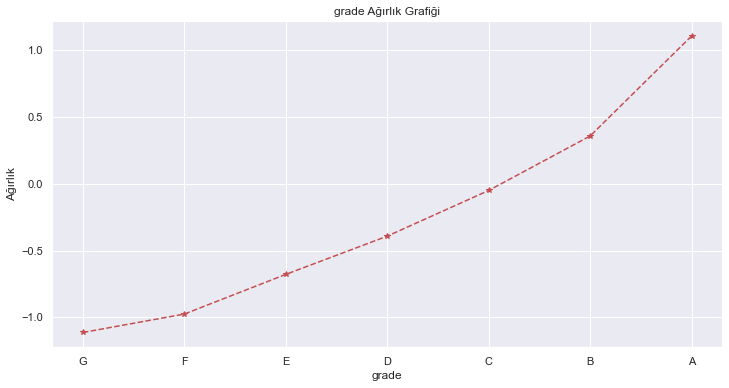

In [63]:
agirlik_plot(grade_iv)

### Home Ownership 

In [64]:
home_ownership_iv=iv_cal(X_train, 'home_ownership', y_train)
home_ownership_iv

,home_ownership,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,OTHER,137,0.795620,0.000367,109.0,28.0,0.000328,0.000687,-0.738602,NaN,NaN,inf
1,NONE,40,0.850000,0.000107,34.0,6.0,0.000102,0.000147,-0.363144,0.054380,0.375458,inf
2,RENT,150599,0.873870,0.403720,131604.0,18995.0,0.396099,0.465815,-0.162123,0.023870,0.201021,inf
3,OWN,33295,0.892536,0.089256,29717.0,3578.0,0.089442,0.087743,0.019170,0.018666,0.181294,inf
4,MORTGAGE,188956,0.903835,0.506546,170785.0,18171.0,0.514026,0.445608,0.142834,0.011298,0.123663,inf
5,ANY,1,1.000000,0.000003,1.0,0.0,0.000003,0.000000,inf,0.096165,inf,inf


other, none ve any için çok çok az sayıda kredi var, ağırlıkları da düşük, silmektense ağırlığı düşük olan rent kategorisine ekliyorum

In [65]:
X_train['home_ownership:RENT_OTHER_NONE_ANY'] = sum([X_train['home_ownership:RENT'], X_train['home_ownership:OTHER'],
                                                      X_train['home_ownership:NONE'],X_train['home_ownership:ANY']])

<ipython-input-65-a3ebd12c8e91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['home_ownership:RENT_OTHER_NONE_ANY'] = sum([X_train['home_ownership:RENT'], X_train['home_ownership:OTHER'],


### Adres : addr_state

In [66]:
X_train["addr_state"].unique()

array(['SC', 'NJ', 'GA', 'MA', 'CA', 'IL', 'NC', 'NY', 'TX', 'CT', 'FL',
       'VA', 'UT', 'AZ', 'MD', 'WI', 'MI', 'CO', 'TN', 'IN', 'AL', 'NV',
       'MT', 'RI', 'OR', 'MN', 'KS', 'AK', 'PA', 'OH', 'WA', 'KY', 'OK',
       'MO', 'NM', 'HI', 'WV', 'LA', 'VT', 'AR', 'DC', 'SD', 'NH', 'WY',
       'MS', 'DE', 'IA', 'NE', 'ID', 'ME'], dtype=object)

In [67]:
addr_state_iv=iv_cal(X_train, 'addr_state', y_train)
addr_state_iv

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,addr_state,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,NE,13,0.461538,0.000035,6.0,7.0,0.000018,0.000172,-2.251896,NaN,NaN,inf
1,IA,13,0.769231,0.000035,10.0,3.0,0.000030,0.000074,-0.893772,0.307692,1.358123,inf
2,NV,5221,0.864585,0.013996,4514.0,707.0,0.013586,0.017338,-0.243837,0.095355,0.649935,inf
3,FL,25211,0.875808,0.067585,22080.0,3131.0,0.066456,0.076782,-0.144425,0.011223,0.099411,inf
4,HI,2001,0.877061,0.005364,1755.0,246.0,0.005282,0.006033,-0.132852,0.001253,0.011573,inf
5,AL,4671,0.877328,0.012522,4098.0,573.0,0.012334,0.014052,-0.130376,0.000267,0.002476,inf
6,NM,2075,0.883373,0.005563,1833.0,242.0,0.005517,0.005935,-0.072973,0.006045,0.057403,inf
7,VA,11366,0.883864,0.030470,10046.0,1320.0,0.030236,0.032370,-0.068202,0.000491,0.004771,inf
8,NY,32211,0.883984,0.086350,28474.0,3737.0,0.085701,0.091643,-0.067037,0.000120,0.001165,inf
9,OK,3284,0.884287,0.008804,2904.0,380.0,0.008740,0.009319,-0.064072,0.000304,0.002965,inf


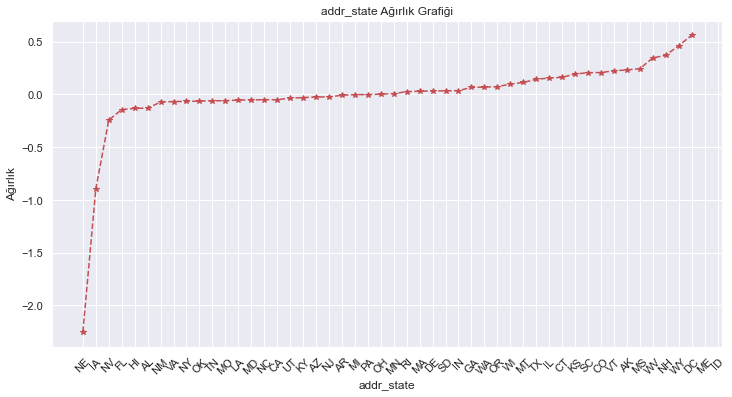

In [68]:
agirlik_plot(addr_state_iv, 45)

Ağırlıklarına göre gruplamak gerekiyor ama burda outliers olanlar kararı etkiliyor, o yüzden outlier'ları gruplayıp çıkarmak gerekiyor, kalanına gruplamak için yeniden bakmak gerekiyor

İlk 2'sini ve son 2 sini çıkarıp bakıyorum (NE, IA grup oldu, ME ve ID'de grup oldu çünkü çok az olduğu için ağırlık çok çıkmış - bir de 0 olarak değerlendirilmesi yok bu şehirdeki kredi kullananların)

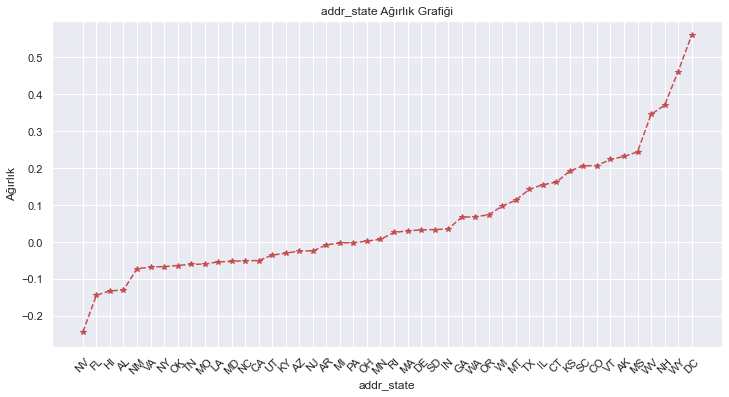

In [69]:
agirlik_plot(addr_state_iv.iloc[2: -2, : ], 45)

NV, FL, HI, AL yine outlier - gruplanabilir

WV, NH, WY, DC outlier - gruplanabilir

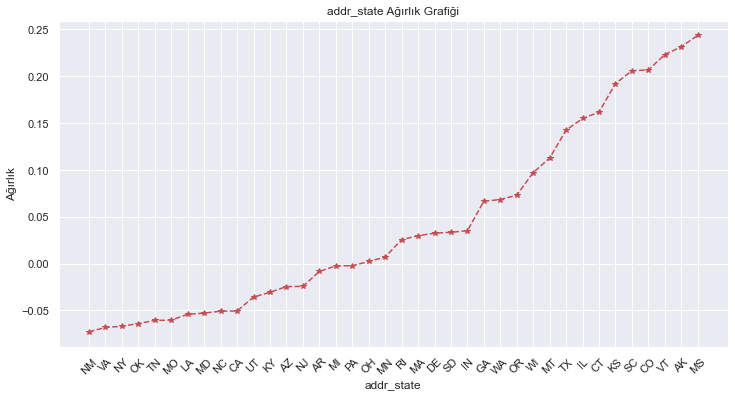

In [70]:
agirlik_plot(addr_state_iv.iloc[6: -6, : ], 45) #şimdi gruplar daha net çıktı

#hem ağırlıklara hem de kredi sayılarına göre grupladım
#eğer yakın ağırlığa sahiplerse ve aralarında birinin kredi sayısı diğerlerine göre çok değilse beraber olacak şekilde grupladım
#mesela NY, CA ve TX çok sayıya sahipti, o yüzden ayrı kategori olarak değerlendirdim
# ND NE IA NV FL HI AL
# NM VA
# NY
# OK TN MO LA MD NC
# CA
# UT KY AZ NJ
# AR MI PA OH MN
# RI MA DE SD IN
# GA WA OR
# WI MT
# TX
# IL CT
# KS SC CO VT AK MS
# WV NH WY DC ME ID

# Hocam, uyarıları bilerek bıraktım, loc ile değiştirmedim, iş yerinde de böyle kullanıyoruz.

In [71]:
#NY, TX ve CA için zaten var, onları bıraktım, diğerlerini birleştiriyorum
X_train['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_train['addr_state:NE'],
                                              X_train['addr_state:IA'], X_train['addr_state:NV'],
                                              X_train['addr_state:FL'], X_train['addr_state:HI'],
                                                          X_train['addr_state:AL']])

X_train['addr_state:NM_VA'] = sum([X_train['addr_state:NM'], X_train['addr_state:VA']])

X_train['addr_state:OK_TN_MO_LA_MD_NC'] = sum([X_train['addr_state:OK'], X_train['addr_state:TN'],
                                              X_train['addr_state:MO'], X_train['addr_state:LA'],
                                              X_train['addr_state:MD'], X_train['addr_state:NC']])

X_train['addr_state:UT_KY_AZ_NJ'] = sum([X_train['addr_state:UT'], X_train['addr_state:KY'],
                                              X_train['addr_state:AZ'], X_train['addr_state:NJ']])

X_train['addr_state:AR_MI_PA_OH_MN'] = sum([X_train['addr_state:AR'], X_train['addr_state:MI'],
                                              X_train['addr_state:PA'], X_train['addr_state:OH'],
                                              X_train['addr_state:MN']])

X_train['addr_state:RI_MA_DE_SD_IN'] = sum([X_train['addr_state:RI'], X_train['addr_state:MA'],
                                              X_train['addr_state:DE'], X_train['addr_state:SD'],
                                              X_train['addr_state:IN']])

X_train['addr_state:GA_WA_OR'] = sum([X_train['addr_state:GA'], X_train['addr_state:WA'],
                                              X_train['addr_state:OR']])

X_train['addr_state:WI_MT'] = sum([X_train['addr_state:WI'], X_train['addr_state:MT']])

X_train['addr_state:IL_CT'] = sum([X_train['addr_state:IL'], X_train['addr_state:CT']])

X_train['addr_state:KS_SC_CO_VT_AK_MS'] = sum([X_train['addr_state:KS'], X_train['addr_state:SC'],
                                              X_train['addr_state:CO'], X_train['addr_state:VT'],
                                              X_train['addr_state:AK'], X_train['addr_state:MS']])

X_train['addr_state:WV_NH_WY_DC_ME_ID'] = sum([X_train['addr_state:WV'], X_train['addr_state:NH'],
                                              X_train['addr_state:WY'], X_train['addr_state:DC'],
                                              X_train['addr_state:ME'], X_train['addr_state:ID']])

<ipython-input-71-356c4dec4fac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_train['addr_state:NE'],
<ipython-input-71-356c4dec4fac>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['addr_state:NM_VA'] = sum([X_train['addr_state:NM'], X_train['addr_state:VA']])
<ipython-input-71-356c4dec4fac>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

### verification status 

In [72]:
verification_status_iv=iv_cal(X_train, 'verification_status', y_train)
verification_status_iv

,verification_status,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,Verified,134414,0.872781,0.360332,117314.0,17100.0,0.353090,0.419344,-0.171969,NaN,NaN,0.020384
1,Source Verified,120030,0.895918,0.321772,107537.0,12493.0,0.323663,0.306366,0.054922,0.023137,0.226891,0.020384
2,Not Verified,118584,0.905679,0.317896,107399.0,11185.0,0.323248,0.274290,0.164232,0.009761,0.109311,0.020384


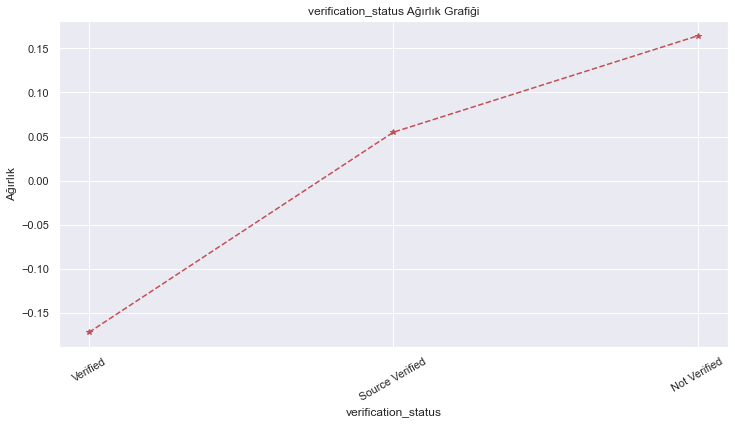

In [73]:
agirlik_plot(verification_status_iv, 30) #bence burada gruplayacak bir şey yok

### purpose 

In [74]:
purpose_iv=iv_cal(X_train, 'purpose', y_train)
purpose_iv

,purpose,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,small_business,5582,0.786098,0.014964,4388.0,1194.0,0.013207,0.029280,-0.796180,NaN,NaN,0.035418
1,educational,333,0.801802,0.000893,267.0,66.0,0.000804,0.001619,-0.700151,0.015704,0.096029,0.035418
2,moving,2392,0.839465,0.006412,2008.0,384.0,0.006044,0.009417,-0.443493,0.037663,0.256658,0.035418
3,house,1830,0.860109,0.004906,1574.0,256.0,0.004737,0.006278,-0.281547,0.020644,0.161946,0.035418
4,other,18884,0.862264,0.050624,16283.0,2601.0,0.049008,0.063784,-0.263519,0.002155,0.018028,0.035418
5,renewable_energy,281,0.864769,0.000753,243.0,38.0,0.000731,0.000932,-0.242270,0.002504,0.021250,0.035418
6,medical,3684,0.868350,0.009876,3199.0,485.0,0.009628,0.011894,-0.211300,0.003581,0.030969,0.035418
7,wedding,1887,0.881823,0.005059,1664.0,223.0,0.005008,0.005469,-0.087937,0.013473,0.123363,0.035418
8,vacation,1991,0.882471,0.005337,1757.0,234.0,0.005288,0.005738,-0.081703,0.000648,0.006234,0.035418
9,debt_consolidation,219183,0.886884,0.587578,194390.0,24793.0,0.585071,0.607999,-0.038440,0.004413,0.043263,0.035418


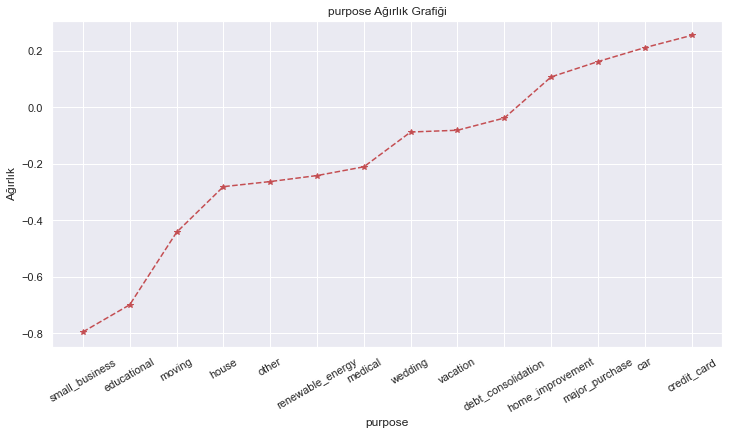

In [75]:
agirlik_plot(purpose_iv, 30)

In [76]:
#sayılara ve ağırlıklara göre
#small_business, educational, moving, renewable_energy, house , wedding
#other,medical,vacation
#major_purchase,car,home_improvement
#debt_consolidtion
#credit_card
X_train['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_train['purpose:educational'], X_train['purpose:small_business'],
                                                                 X_train['purpose:wedding'], X_train['purpose:renewable_energy'],
                                                                 X_train['purpose:moving'], X_train['purpose:house']])
X_train['purpose:oth__med__vacation'] = sum([X_train['purpose:other'], X_train['purpose:medical'],
                                             X_train['purpose:vacation']])
X_train['purpose:major_purch__car__home_impr'] = sum([X_train['purpose:major_purchase'], X_train['purpose:car'],
                                                        X_train['purpose:home_improvement']])

<ipython-input-76-5e0c84f4eecd>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_train['purpose:educational'], X_train['purpose:small_business'],
<ipython-input-76-5e0c84f4eecd>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['purpose:oth__med__vacation'] = sum([X_train['purpose:other'], X_train['purpose:medical'],
<ipython-input-76-5e0c84f4eecd>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

### initial_list_status

In [77]:
initial_list_status_iv=iv_cal(X_train, 'initial_list_status', y_train)
initial_list_status_iv
#burda zaten 2 değer var :)

,initial_list_status,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,f,242514,0.879694,0.650123,213338.0,29176.0,0.642101,0.715484,-0.108214,NaN,NaN,0.02478
1,w,130514,0.911105,0.349877,118912.0,11602.0,0.357899,0.284516,0.229461,0.031412,0.337675,0.02478


## Kategorik olmayan değişkenlerde ağırlığa göre sıralamaya gerek yok çünkü zaten kendileri büyüklük olarak sıralı, o yüzden sıralamasız haliyle fonksiyon: 

In [78]:
def iv_cal_con(df, variable_name, loan_status_pd):
    df = pd.concat([df[variable_name], loan_status_pd], axis = 1)
    df = pd.concat([df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0], as_index = False)[df.columns.values[1]].mean()], axis = 1)
    df = df.iloc[:, [0, 1, 3]]
    df.columns = [df.columns.values[0], 'n_obs', 'prop_1']
    df['prop_n_obs'] = df['n_obs'] / df['n_obs'].sum()
    df['n_1'] = df['prop_1'] * df['n_obs']
    df['n_0'] = (1 - df['prop_1']) * df['n_obs']
    df['prop_n_1'] = df['n_1'] / df['n_1'].sum()
    df['prop_n_0'] = df['n_0'] / df['n_0'].sum()
    df['Agirlik'] = np.log(df['prop_n_1'] / df['prop_n_0'])
    df['diff_prop_1'] = df['prop_1'].diff().abs()
    df['diff_Agirlik'] = df['Agirlik'].diff().abs()
    df['IV'] = (df['prop_n_1'] - df['prop_n_0']) * df['Agirlik'] #IV = information value
    df['IV'] = df['IV'].sum()
    return df

### Term 

In [79]:
#Zaten term_int 36 60 olarak düzenlemiştim
term_iv=iv_cal_con(X_train, 'term_int', y_train)
term_iv

,term_int,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,36,270419,0.902995,0.724929,244187.0,26232.0,0.73495,0.643288,0.133209,NaN,NaN,0.039434
1,60,102609,0.858239,0.275071,88063.0,14546.0,0.26505,0.356712,-0.297009,0.044756,0.430218,0.039434


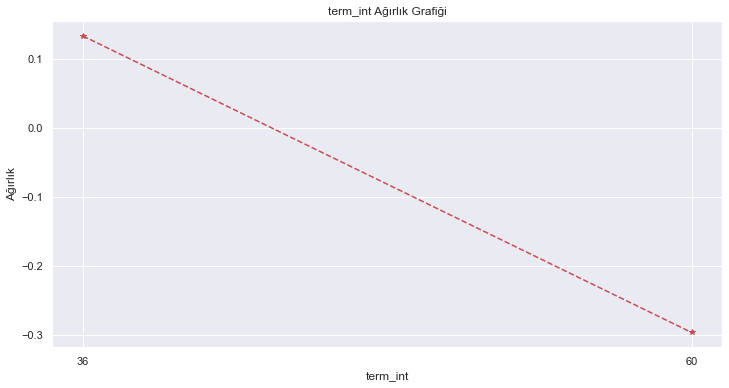

In [80]:
agirlik_plot(term_iv)

In [81]:
#36 ve 60'ı sayı olarak modele sokarsam saçma değerler olacak, 0 veya 1 elde etmeye çalışıyoruz çünkü, 
#36 ve 60 için birer dummy değişken oluşturuyorum
X_train['term:36'] = np.where((X_train['term_int'] == 36), 1, 0)
X_train['term:60'] = np.where((X_train['term_int'] == 60), 1, 0)

<ipython-input-81-cb059c272402>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['term:36'] = np.where((X_train['term_int'] == 36), 1, 0)
<ipython-input-81-cb059c272402>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['term:60'] = np.where((X_train['term_int'] == 60), 1, 0)


### emp_length

In [82]:
#Zaten emp_length_int olarak düzenlemiştim
emp_length_iv=iv_cal_con(X_train, 'emp_length_int', y_train)
emp_length_iv

,emp_length_int,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,0.0,45720,0.876400,0.122565,40069.0,5651.0,0.120599,0.138580,-0.138975,NaN,NaN,0.006506
1,1.0,23654,0.886996,0.063411,20981.0,2673.0,0.063148,0.065550,-0.037329,0.010596,0.101645,0.006506
2,2.0,33078,0.890955,0.088674,29471.0,3607.0,0.088701,0.088455,0.002785,0.003959,0.040114,0.006506
3,3.0,29205,0.890772,0.078292,26015.0,3190.0,0.078299,0.078228,0.000907,0.000183,0.001878,0.006506
4,4.0,22468,0.890644,0.060231,20011.0,2457.0,0.060229,0.060253,-0.000404,0.000128,0.001311,0.006506
5,5.0,24602,0.884725,0.065952,21766.0,2836.0,0.065511,0.069547,-0.059790,0.005920,0.059387,0.006506
6,6.0,20887,0.883899,0.055993,18462.0,2425.0,0.055567,0.059468,-0.067862,0.000826,0.008071,0.006506
7,7.0,21049,0.887453,0.056427,18680.0,2369.0,0.056223,0.058095,-0.032759,0.003554,0.035102,0.006506
8,8.0,17853,0.889878,0.047860,15887.0,1966.0,0.047816,0.048212,-0.008245,0.002425,0.024515,0.006506
9,9.0,14267,0.886662,0.038246,12650.0,1617.0,0.038074,0.039654,-0.040660,0.003217,0.032416,0.006506


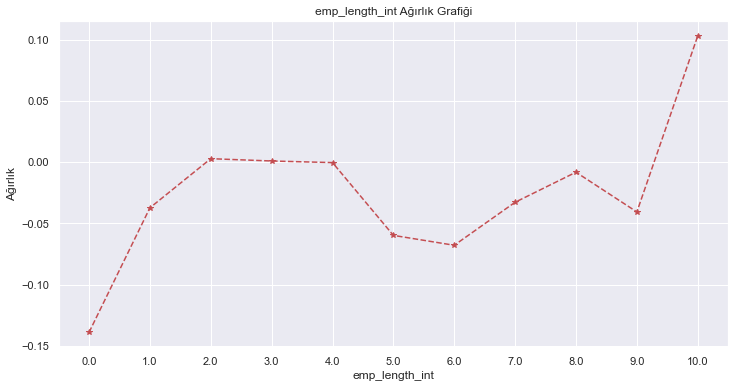

In [83]:
agirlik_plot(emp_length_iv) #kategoriler açık şekilde görülüyor

In [84]:
# 0 / 1 / 2 - 4 / 5 - 6 / 7 - 9 / 10
X_train['emp_length:0'] = np.where(X_train['emp_length_int'].isin([0]), 1, 0)
X_train['emp_length:1'] = np.where(X_train['emp_length_int'].isin([1]), 1, 0)
X_train['emp_length:2-4'] = np.where(X_train['emp_length_int'].isin(range(2, 5)), 1, 0)
X_train['emp_length:5-6'] = np.where(X_train['emp_length_int'].isin(range(5, 7)), 1, 0)
X_train['emp_length:7-9'] = np.where(X_train['emp_length_int'].isin(range(7, 10)), 1, 0)
X_train['emp_length:10'] = np.where(X_train['emp_length_int'].isin([10]), 1, 0)

<ipython-input-84-9884eb7c0ebf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['emp_length:0'] = np.where(X_train['emp_length_int'].isin([0]), 1, 0)
<ipython-input-84-9884eb7c0ebf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['emp_length:1'] = np.where(X_train['emp_length_int'].isin([1]), 1, 0)
<ipython-input-84-9884eb7c0ebf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### mths_since_issue_d 

In [85]:
X_train['mths_since_issue_d'].unique()

array([ 81., 100.,  90.,  80., 137.,  73., 127.,  89.,  78.,  93.,  94.,
        79.,  76.,  87.,  95., 149.,  86.,  98.,  85.,  83.,  84.,  77.,
        74., 102., 105., 123.,  82., 112.,  99.,  75.,  97., 125., 101.,
        92., 115., 104.,  88.,  96., 109., 110., 106., 124., 117., 118.,
        91., 139., 119., 108., 121.,  72., 107., 128., 113., 103., 120.,
       122., 126., 152., 129., 131., 114., 111., 116., 132., 130., 134.,
       140., 161., 141., 154., 146., 155., 150., 133., 138., 142., 136.,
       158., 157., 144., 153., 156., 160., 135., 151., 148., 145., 159.,
       143., 162., 147.])

In [86]:
X_train['mths_since_issue_d_factor'] = pd.cut(X_train['mths_since_issue_d'], 50)

<ipython-input-86-c5503de206dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_issue_d_factor'] = pd.cut(X_train['mths_since_issue_d'], 50)


In [87]:
X_train['mths_since_issue_d_factor']

427211      (79.2, 81.0]
206088     (99.0, 100.8]
136020      (88.2, 90.0]
412305      (79.2, 81.0]
36159     (136.8, 138.6]
               ...      
259178     (71.91, 73.8]
365838      (77.4, 79.2]
131932      (88.2, 90.0]
146867      (91.8, 93.6]
121958      (88.2, 90.0]
Name: mths_since_issue_d_factor, Length: 373028, dtype: category
Categories (50, interval[float64]): [(71.91, 73.8] < (73.8, 75.6] < (75.6, 77.4] < (77.4, 79.2] ... (154.8, 156.6] < (156.6, 158.4] < (158.4, 160.2] < (160.2, 162.0]]

In [88]:
mths_since_issue_d_factor_iv=iv_cal_con(X_train, 'mths_since_issue_d_factor', y_train)
mths_since_issue_d_factor_iv

,mths_since_issue_d_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(71.91, 73.8]",28170,0.942244,0.075517,26543.0,1627.0,0.079889,0.039899,0.694283,NaN,NaN,0.113186
1,"(73.8, 75.6]",39636,0.928424,0.106255,36799.0,2837.0,0.110757,0.069572,0.464979,0.013820,0.229305,0.113186
2,"(75.6, 77.4]",38614,0.917284,0.103515,35420.0,3194.0,0.106606,0.078327,0.308258,0.011140,0.156721,0.113186
3,"(77.4, 79.2]",29038,0.908603,0.077844,26384.0,2654.0,0.079410,0.065084,0.198945,0.008681,0.109313,0.113186
4,"(79.2, 81.0]",28367,0.901787,0.076045,25581.0,2786.0,0.076993,0.068321,0.119498,0.006815,0.079447,0.113186
5,"(81.0, 82.8]",12165,0.899301,0.032611,10940.0,1225.0,0.032927,0.030041,0.091740,0.002486,0.027758,0.113186
6,"(82.8, 84.6]",24451,0.898900,0.065547,21979.0,2472.0,0.066152,0.060621,0.087315,0.000401,0.004425,0.113186
7,"(84.6, 86.4]",22969,0.888328,0.061574,20404.0,2565.0,0.061412,0.062902,-0.023972,0.010572,0.111287,0.113186
8,"(86.4, 88.2]",20640,0.880523,0.055331,18174.0,2466.0,0.054700,0.060474,-0.100350,0.007804,0.076378,0.113186
9,"(88.2, 90.0]",18312,0.866863,0.049090,15874.0,2438.0,0.047777,0.059787,-0.224240,0.013660,0.123890,0.113186


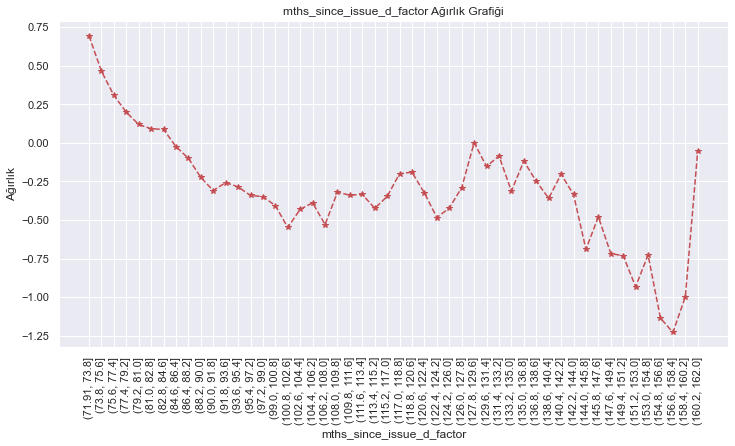

In [89]:
agirlik_plot(mths_since_issue_d_factor_iv, 90)

In [90]:
# < 70, 70 - 71, 72 - 73, 74 - 80, 81 - 84, 85 - 96, 97 - 116, > 116
X_train['mths_since_issue_d:<70'] = np.where(X_train['mths_since_issue_d'].isin(range(70)), 1, 0)
X_train['mths_since_issue_d:70-71'] = np.where(X_train['mths_since_issue_d'].isin(range(70, 72)), 1, 0)
X_train['mths_since_issue_d:72-73'] = np.where(X_train['mths_since_issue_d'].isin(range(72, 74)), 1, 0)
X_train['mths_since_issue_d:74-80'] = np.where(X_train['mths_since_issue_d'].isin(range(74, 81)), 1, 0)
X_train['mths_since_issue_d:81-84'] = np.where(X_train['mths_since_issue_d'].isin(range(81, 85)), 1, 0)
X_train['mths_since_issue_d:85-96'] = np.where(X_train['mths_since_issue_d'].isin(range(85, 97)), 1, 0)
X_train['mths_since_issue_d:97-116'] = np.where(X_train['mths_since_issue_d'].isin(range(97, 117)), 1, 0)
X_train['mths_since_issue_d:>116'] = np.where(X_train['mths_since_issue_d'].isin(range(117, int(X_train['mths_since_issue_d'].max()))), 1, 0)

<ipython-input-90-6cac4df8a99c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_issue_d:<70'] = np.where(X_train['mths_since_issue_d'].isin(range(70)), 1, 0)
<ipython-input-90-6cac4df8a99c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_issue_d:70-71'] = np.where(X_train['mths_since_issue_d'].isin(range(70, 72)), 1, 0)
<ipython-input-90-6cac4df8a99c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

### int_rate_factor

In [91]:
X_train["int_rate_factor"]=pd.cut(X_train['int_rate'], 50)

<ipython-input-91-d777336cdcb6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train["int_rate_factor"]=pd.cut(X_train['int_rate'], 50)


In [92]:
int_rate_factor_iv=iv_cal_con(X_train, 'int_rate_factor', y_train)
int_rate_factor_iv

,int_rate_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(5.399, 5.833]",785,0.961783,0.002104,755.0,30.0,0.002272,0.000736,1.127775,NaN,NaN,0.343349
1,"(5.833, 6.246]",8459,0.980376,0.022677,8293.0,166.0,0.024960,0.004071,1.813434,0.018592,0.685659,0.343349
2,"(6.246, 6.658]",7826,0.971505,0.020980,7603.0,223.0,0.022883,0.005469,1.431381,0.008871,0.382053,0.343349
3,"(6.658, 7.071]",1816,0.973018,0.004868,1767.0,49.0,0.005318,0.001202,1.487473,0.001512,0.056092,0.343349
4,"(7.071, 7.484]",3143,0.976456,0.008426,3069.0,74.0,0.009237,0.001815,1.627297,0.003438,0.139824,0.343349
5,"(7.484, 7.897]",12581,0.962324,0.033727,12107.0,474.0,0.036439,0.011624,1.142587,0.014131,0.484710,0.343349
6,"(7.897, 8.31]",9687,0.949314,0.025969,9196.0,491.0,0.027678,0.012041,0.832335,0.013011,0.310252,0.343349
7,"(8.31, 8.722]",6594,0.965271,0.017677,6365.0,229.0,0.019157,0.005616,1.227103,0.015958,0.394768,0.343349
8,"(8.722, 9.135]",9539,0.937415,0.025572,8942.0,597.0,0.026913,0.014640,0.608852,0.027857,0.618250,0.343349
9,"(9.135, 9.548]",6681,0.963928,0.017910,6440.0,241.0,0.019383,0.005910,1.187742,0.026513,0.578889,0.343349


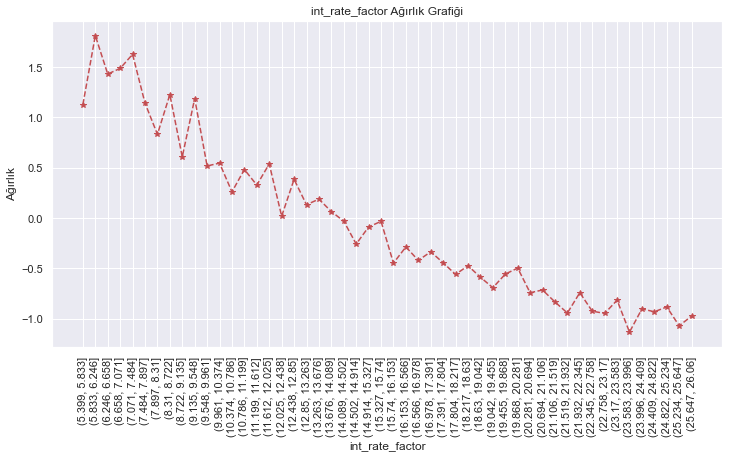

In [93]:
agirlik_plot(int_rate_factor_iv, 90)

In [94]:
# '< 9.548', '9.548 - 12.025', '12.025 - 15.74', '15.74 - 20.281', '> 20.281'
X_train['int_rate:<9.548'] = np.where((X_train['int_rate'] <= 9.548), 1, 0)
X_train['int_rate:9.548-12.025'] = np.where((X_train['int_rate'] > 9.548) & (X_train['int_rate'] <= 12.025), 1, 0)
X_train['int_rate:12.025-15.74'] = np.where((X_train['int_rate'] > 12.025) & (X_train['int_rate'] <= 15.74), 1, 0)
X_train['int_rate:15.74-20.281'] = np.where((X_train['int_rate'] > 15.74) & (X_train['int_rate'] <= 20.281), 1, 0)
X_train['int_rate:>20.281'] = np.where((X_train['int_rate'] > 20.281), 1, 0)

<ipython-input-94-d1f94bf26d5c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['int_rate:<9.548'] = np.where((X_train['int_rate'] <= 9.548), 1, 0)
<ipython-input-94-d1f94bf26d5c>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['int_rate:9.548-12.025'] = np.where((X_train['int_rate'] > 9.548) & (X_train['int_rate'] <= 12.025), 1, 0)
<ipython-input-94-d1f94bf26d5c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

### mths_since_earliest_cr_line 

In [95]:
X_train['mths_since_earliest_cr_line_factor'] = pd.cut(X_train['mths_since_earliest_cr_line'], 50)
mths_since_earliest_cr_line_factor_iv = iv_cal_con(X_train, 'mths_since_earliest_cr_line_factor', y_train)
mths_since_earliest_cr_line_factor_iv

<ipython-input-95-631b6b8f9b32>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_earliest_cr_line_factor'] = pd.cut(X_train['mths_since_earliest_cr_line'], 50)


,mths_since_earliest_cr_line_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(-0.623, 12.46]",24,0.875000,0.000064,21.0,3.0,0.000063,0.000074,-0.151835,NaN,NaN,0.016381
1,"(12.46, 24.92]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
2,"(24.92, 37.38]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
3,"(37.38, 49.84]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
4,"(49.84, 62.3]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
5,"(62.3, 74.76]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
6,"(74.76, 87.22]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
7,"(87.22, 99.68]",0,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016381
8,"(99.68, 112.14]",146,0.863014,0.000391,126.0,20.0,0.000379,0.000490,-0.257195,NaN,NaN,0.016381
9,"(112.14, 124.6]",1669,0.901738,0.004474,1505.0,164.0,0.004530,0.004022,0.118937,0.038724,0.376132,0.016381


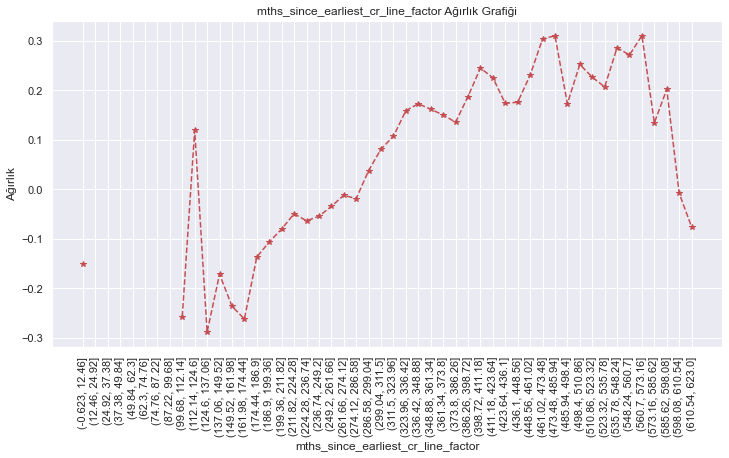

In [96]:
agirlik_plot(mths_since_earliest_cr_line_factor_iv, 90)

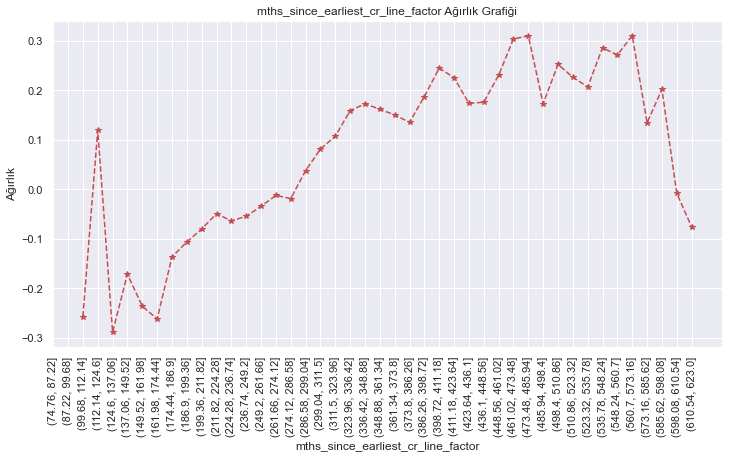

In [97]:
agirlik_plot(mths_since_earliest_cr_line_factor_iv.iloc[6: , : ], 90)
# We plot the weight of evidence values.

In [98]:
# < 140, # 141 - 164, # 165 - 247, # 248 - 270, # 271 - 352, # > 352
X_train['mths_since_earliest_cr_line:<140'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
X_train['mths_since_earliest_cr_line:141-164'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
X_train['mths_since_earliest_cr_line:165-247'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
X_train['mths_since_earliest_cr_line:248-270'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
X_train['mths_since_earliest_cr_line:271-352'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
X_train['mths_since_earliest_cr_line:>352'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(353, int(X_train['mths_since_earliest_cr_line'].max()))), 1, 0)

<ipython-input-98-3aa5a0222deb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_earliest_cr_line:<140'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
<ipython-input-98-3aa5a0222deb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_earliest_cr_line:141-164'] = np.where(X_train['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
<ipython-input-98-3aa5a0222deb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

### delinq_2yrs 

In [99]:
delinq_2yrs_iv = iv_cal_con(X_train, 'delinq_2yrs', y_train)
delinq_2yrs_iv

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,delinq_2yrs,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,0.0,306417,0.890499,0.821432,272864.0,33553.0,0.821261,0.822821,-0.001898,NaN,NaN,inf
1,1.0,44927,0.893249,0.120439,40131.0,4796.0,0.120786,0.117612,0.026622,0.002750,0.028520,inf
2,2.0,13118,0.889007,0.035166,11662.0,1456.0,0.035100,0.035706,-0.017102,0.004242,0.043724,inf
3,3.0,4550,0.883297,0.012197,4019.0,531.0,0.012096,0.013022,-0.073719,0.005711,0.056616,inf
4,4.0,1868,0.898822,0.005008,1679.0,189.0,0.005053,0.004635,0.086462,0.015526,0.160180,inf
5,5.0,966,0.881988,0.002590,852.0,114.0,0.002564,0.002796,-0.086357,0.016835,0.172819,inf
6,6.0,501,0.902196,0.001343,452.0,49.0,0.001360,0.001202,0.124117,0.020208,0.210474,inf
7,7.0,279,0.860215,0.000748,240.0,39.0,0.000722,0.000956,-0.280668,0.041981,0.404785,inf
8,8.0,148,0.905405,0.000397,134.0,14.0,0.000403,0.000343,0.161037,0.045190,0.441705,inf
9,9.0,89,0.887640,0.000239,79.0,10.0,0.000238,0.000245,-0.030882,0.017765,0.191920,inf


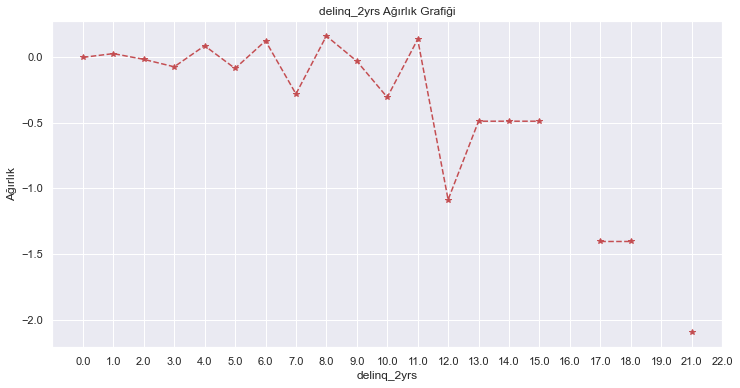

In [100]:
agirlik_plot(delinq_2yrs_iv)

In [101]:
#0, 1-3, >=4
X_train['delinq_2yrs:0'] = np.where((X_train['delinq_2yrs'] == 0), 1, 0)
X_train['delinq_2yrs:1-3'] = np.where((X_train['delinq_2yrs'] >= 1) & (X_train['delinq_2yrs'] <= 3), 1, 0)
X_train['delinq_2yrs:>=4'] = np.where((X_train['delinq_2yrs'] >= 9), 1, 0)

<ipython-input-101-33e212006ea7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['delinq_2yrs:0'] = np.where((X_train['delinq_2yrs'] == 0), 1, 0)
<ipython-input-101-33e212006ea7>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['delinq_2yrs:1-3'] = np.where((X_train['delinq_2yrs'] >= 1) & (X_train['delinq_2yrs'] <= 3), 1, 0)
<ipython-input-101-33e212006ea7>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

### inq_last_6mths

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


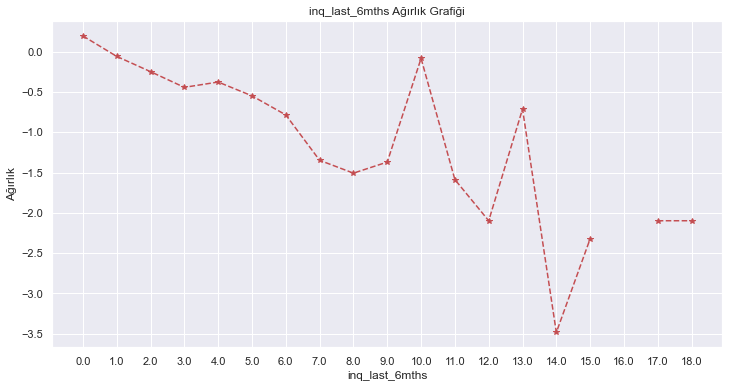

In [102]:
inq_last_6mths_iv = iv_cal_con(X_train, 'inq_last_6mths', y_train)
inq_last_6mths_iv
agirlik_plot(inq_last_6mths_iv)

In [103]:
#0, 1 - 2, 3 - 6, > 6
X_train['inq_last_6mths:0'] = np.where((X_train['inq_last_6mths'] == 0), 1, 0)
X_train['inq_last_6mths:1-2'] = np.where((X_train['inq_last_6mths'] >= 1) & (X_train['inq_last_6mths'] <= 2), 1, 0)
X_train['inq_last_6mths:3-6'] = np.where((X_train['inq_last_6mths'] >= 3) & (X_train['inq_last_6mths'] <= 6), 1, 0)
X_train['inq_last_6mths:>6'] = np.where((X_train['inq_last_6mths'] > 6), 1, 0)

<ipython-input-103-77acfc7fdd95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['inq_last_6mths:0'] = np.where((X_train['inq_last_6mths'] == 0), 1, 0)
<ipython-input-103-77acfc7fdd95>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['inq_last_6mths:1-2'] = np.where((X_train['inq_last_6mths'] >= 1) & (X_train['inq_last_6mths'] <= 2), 1, 0)
<ipython-input-103-77acfc7fdd95>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

### open_acc 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


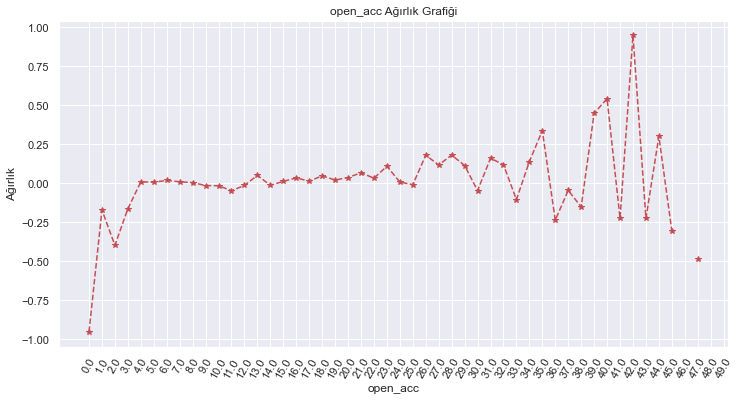

In [104]:
open_acc_iv = iv_cal_con(X_train, 'open_acc', y_train)
open_acc_iv
agirlik_plot(open_acc_iv, 60)

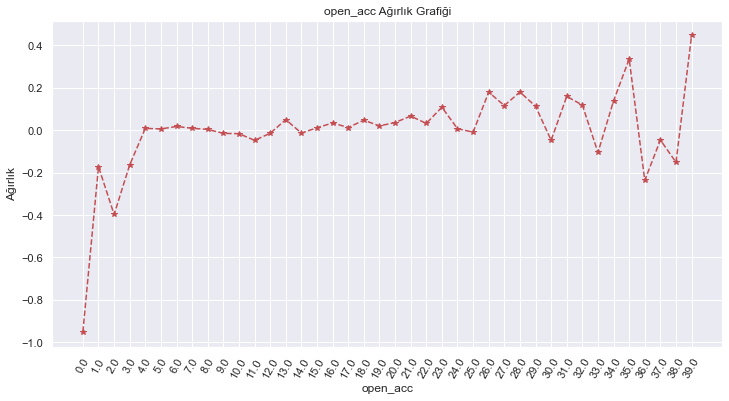

In [105]:
agirlik_plot(open_acc_iv.iloc[ : 40, :], 60)

In [106]:
#'0', '1-3', '4-12', '13-17', '18-22', '23-25', '26-30', '>30'
X_train['open_acc:0'] = np.where((X_train['open_acc'] == 0), 1, 0)
X_train['open_acc:1-3'] = np.where((X_train['open_acc'] >= 1) & (X_train['open_acc'] <= 3), 1, 0)
X_train['open_acc:4-12'] = np.where((X_train['open_acc'] >= 4) & (X_train['open_acc'] <= 12), 1, 0)
X_train['open_acc:13-17'] = np.where((X_train['open_acc'] >= 13) & (X_train['open_acc'] <= 17), 1, 0)
X_train['open_acc:18-22'] = np.where((X_train['open_acc'] >= 18) & (X_train['open_acc'] <= 22), 1, 0)
X_train['open_acc:23-25'] = np.where((X_train['open_acc'] >= 23) & (X_train['open_acc'] <= 25), 1, 0)
X_train['open_acc:26-30'] = np.where((X_train['open_acc'] >= 26) & (X_train['open_acc'] <= 30), 1, 0)
X_train['open_acc:>=31'] = np.where((X_train['open_acc'] >= 31), 1, 0)

<ipython-input-106-e940d85bc441>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['open_acc:0'] = np.where((X_train['open_acc'] == 0), 1, 0)
<ipython-input-106-e940d85bc441>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['open_acc:1-3'] = np.where((X_train['open_acc'] >= 1) & (X_train['open_acc'] <= 3), 1, 0)
<ipython-input-106-e940d85bc441>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

### pub_rec 

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


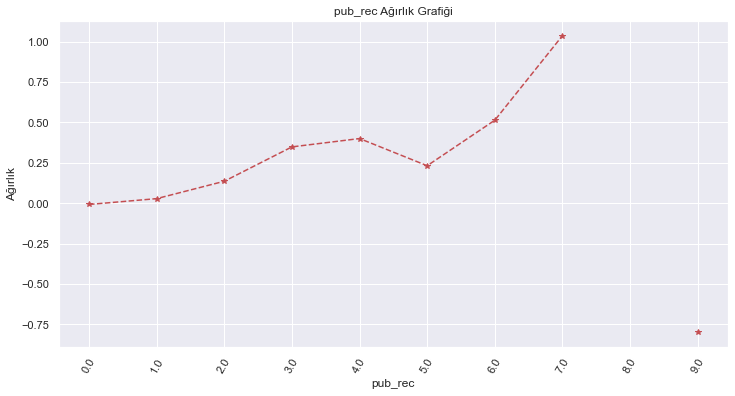

In [107]:
pub_rec_iv = iv_cal_con(X_train, 'pub_rec', y_train)
pub_rec_iv
agirlik_plot(pub_rec_iv, 60)

In [108]:
#'0-2', '3-4', '>=5'
X_train['pub_rec:0-2'] = np.where((X_train['pub_rec'] >= 0) & (X_train['pub_rec'] <= 2), 1, 0)
X_train['pub_rec:3-4'] = np.where((X_train['pub_rec'] >= 3) & (X_train['pub_rec'] <= 4), 1, 0)
X_train['pub_rec:>=5'] = np.where((X_train['pub_rec'] >= 5), 1, 0)

<ipython-input-108-fb2c676089dd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pub_rec:0-2'] = np.where((X_train['pub_rec'] >= 0) & (X_train['pub_rec'] <= 2), 1, 0)
<ipython-input-108-fb2c676089dd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['pub_rec:3-4'] = np.where((X_train['pub_rec'] >= 3) & (X_train['pub_rec'] <= 4), 1, 0)
<ipython-input-108-fb2c676089dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

### total_acc 

<ipython-input-109-e099973283eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_acc_factor'] = pd.cut(X_train['total_acc'], 50)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


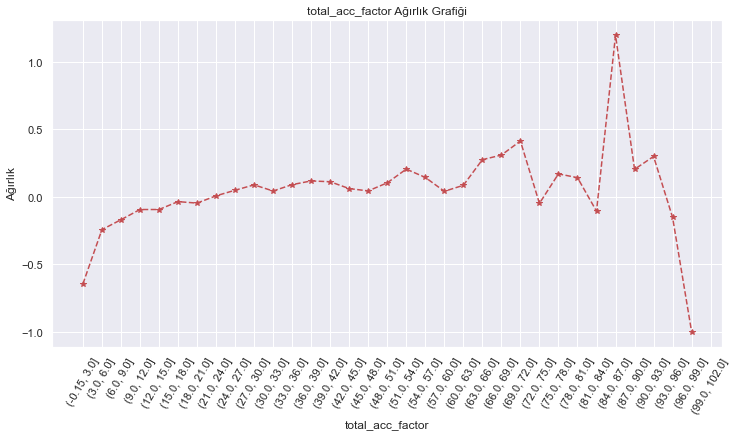

In [109]:
# total_acc
X_train['total_acc_factor'] = pd.cut(X_train['total_acc'], 50)
total_acc_factor_iv = iv_cal_con(X_train, 'total_acc_factor', y_train)
total_acc_factor_iv
agirlik_plot(total_acc_factor_iv, 60)

In [110]:
#'<=27', '28-51', '>51'
X_train['total_acc:<=27'] = np.where((X_train['total_acc'] <= 27), 1, 0)
X_train['total_acc:28-51'] = np.where((X_train['total_acc'] >= 28) & (X_train['total_acc'] <= 51), 1, 0)
X_train['total_acc:>=52'] = np.where((X_train['total_acc'] >= 52), 1, 0)

<ipython-input-110-3747b3981cef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_acc:<=27'] = np.where((X_train['total_acc'] <= 27), 1, 0)
<ipython-input-110-3747b3981cef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_acc:28-51'] = np.where((X_train['total_acc'] >= 28) & (X_train['total_acc'] <= 51), 1, 0)
<ipython-input-110-3747b3981cef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

### acc_now_delinq

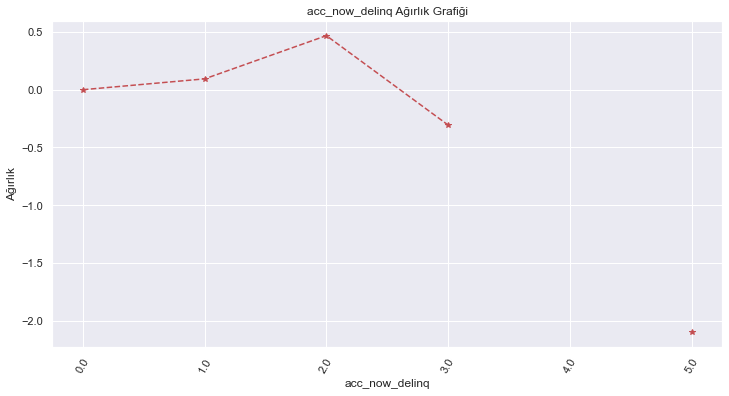

In [111]:
acc_now_delinq_iv = iv_cal_con(X_train, 'acc_now_delinq', y_train)
acc_now_delinq_iv
agirlik_plot(acc_now_delinq_iv, 60)

In [112]:
# '0', '>=1'
X_train['acc_now_delinq:0'] = np.where((X_train['acc_now_delinq'] == 0), 1, 0)
X_train['acc_now_delinq:>=1'] = np.where((X_train['acc_now_delinq'] >= 1), 1, 0)

<ipython-input-112-6b594749b335>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['acc_now_delinq:0'] = np.where((X_train['acc_now_delinq'] == 0), 1, 0)
<ipython-input-112-6b594749b335>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['acc_now_delinq:>=1'] = np.where((X_train['acc_now_delinq'] >= 1), 1, 0)


### total_rev_hi_lim

<ipython-input-113-ca54247dc203>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_rev_hi_lim_factor'] = pd.cut(X_train['total_rev_hi_lim'], 2000)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


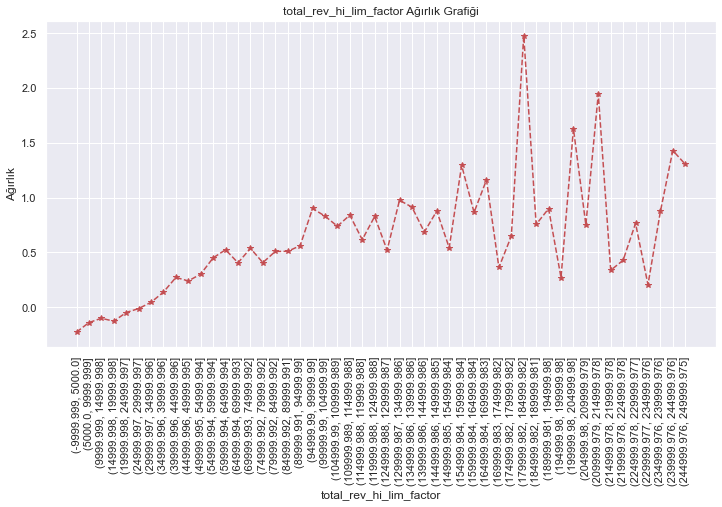

In [113]:
# total_rev_hi_lim
X_train['total_rev_hi_lim_factor'] = pd.cut(X_train['total_rev_hi_lim'], 2000)
total_rev_hi_lim_factor_iv = iv_cal_con(X_train, 'total_rev_hi_lim_factor', y_train)
agirlik_plot(total_rev_hi_lim_factor_iv.iloc[: 50, : ], 90)

In [114]:
# '<=5K', '5K-10K', '10K-20K', '20K-30K', '30K-40K', '40K-55K', '55K-95K', '>95K'
X_train['total_rev_hi_lim:<=5K'] = np.where((X_train['total_rev_hi_lim'] <= 5000), 1, 0)
X_train['total_rev_hi_lim:5K-10K'] = np.where((X_train['total_rev_hi_lim'] > 5000) & (X_train['total_rev_hi_lim'] <= 10000), 1, 0)
X_train['total_rev_hi_lim:10K-20K'] = np.where((X_train['total_rev_hi_lim'] > 10000) & (X_train['total_rev_hi_lim'] <= 20000), 1, 0)
X_train['total_rev_hi_lim:20K-30K'] = np.where((X_train['total_rev_hi_lim'] > 20000) & (X_train['total_rev_hi_lim'] <= 30000), 1, 0)
X_train['total_rev_hi_lim:30K-40K'] = np.where((X_train['total_rev_hi_lim'] > 30000) & (X_train['total_rev_hi_lim'] <= 40000), 1, 0)
X_train['total_rev_hi_lim:40K-55K'] = np.where((X_train['total_rev_hi_lim'] > 40000) & (X_train['total_rev_hi_lim'] <= 55000), 1, 0)
X_train['total_rev_hi_lim:55K-95K'] = np.where((X_train['total_rev_hi_lim'] > 55000) & (X_train['total_rev_hi_lim'] <= 95000), 1, 0)
X_train['total_rev_hi_lim:>95K'] = np.where((X_train['total_rev_hi_lim'] > 95000), 1, 0)

<ipython-input-114-7edce565abe2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_rev_hi_lim:<=5K'] = np.where((X_train['total_rev_hi_lim'] <= 5000), 1, 0)
<ipython-input-114-7edce565abe2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['total_rev_hi_lim:5K-10K'] = np.where((X_train['total_rev_hi_lim'] > 5000) & (X_train['total_rev_hi_lim'] <= 10000), 1, 0)
<ipython-input-114-7edce565abe2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


### installment 

<ipython-input-115-e5e6f532289a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['installment_factor'] = pd.cut(X_train['installment'], 50)


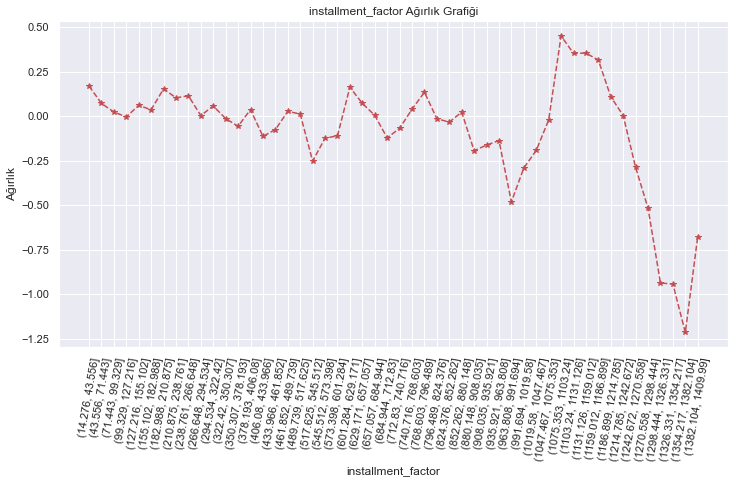

In [115]:
X_train['installment_factor'] = pd.cut(X_train['installment'], 50)
installment_factor_iv = iv_cal_con(X_train, 'installment_factor', y_train)
agirlik_plot(installment_factor_iv, 80)

### annual_inc 

<ipython-input-116-0917da905305>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 100)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


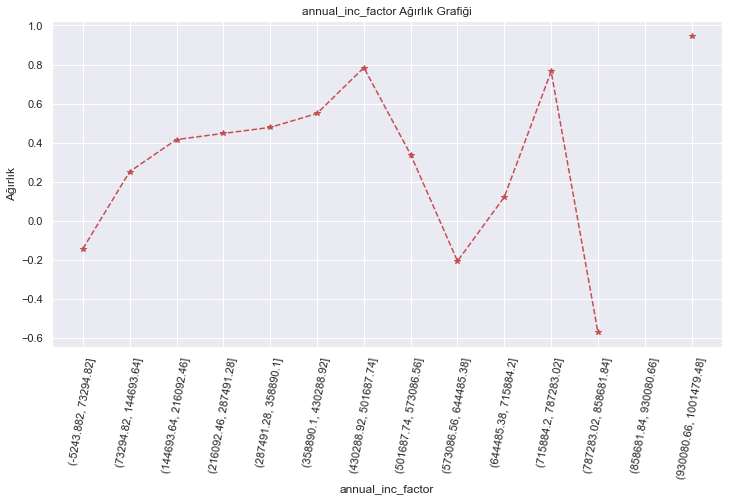

In [116]:
X_train['annual_inc_factor'] = pd.cut(X_train['annual_inc'], 100)
annual_inc_factor_iv = iv_cal_con(X_train, 'annual_inc_factor', y_train)
agirlik_plot(annual_inc_factor_iv, 80)

In [117]:
X_train_temp = X_train.loc[X_train['annual_inc'] <= 140000, : ]

<ipython-input-118-690093712254>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_temp["annual_inc_factor"] = pd.cut(X_train_temp['annual_inc'], 50)


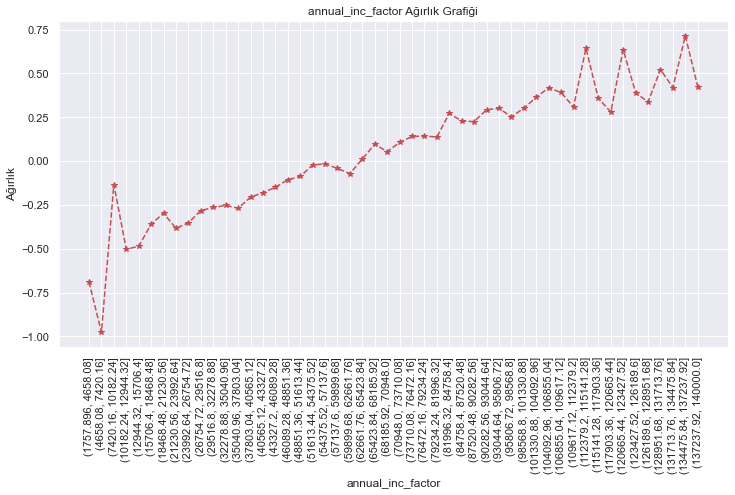

In [118]:
X_train_temp["annual_inc_factor"] = pd.cut(X_train_temp['annual_inc'], 50)
df_temp = iv_cal_con(X_train_temp, 'annual_inc_factor', y_train[X_train_temp.index])
agirlik_plot(df_temp, 90)

In [119]:
X_train['annual_inc:<20K'] = np.where((X_train['annual_inc'] <= 20000), 1, 0)
X_train['annual_inc:20K-30K'] = np.where((X_train['annual_inc'] > 20000) & (X_train['annual_inc'] <= 30000), 1, 0)
X_train['annual_inc:30K-40K'] = np.where((X_train['annual_inc'] > 30000) & (X_train['annual_inc'] <= 40000), 1, 0)
X_train['annual_inc:40K-50K'] = np.where((X_train['annual_inc'] > 40000) & (X_train['annual_inc'] <= 50000), 1, 0)
X_train['annual_inc:50K-60K'] = np.where((X_train['annual_inc'] > 50000) & (X_train['annual_inc'] <= 60000), 1, 0)
X_train['annual_inc:60K-70K'] = np.where((X_train['annual_inc'] > 60000) & (X_train['annual_inc'] <= 70000), 1, 0)
X_train['annual_inc:70K-80K'] = np.where((X_train['annual_inc'] > 70000) & (X_train['annual_inc'] <= 80000), 1, 0)
X_train['annual_inc:80K-90K'] = np.where((X_train['annual_inc'] > 80000) & (X_train['annual_inc'] <= 90000), 1, 0)
X_train['annual_inc:90K-100K'] = np.where((X_train['annual_inc'] > 90000) & (X_train['annual_inc'] <= 100000), 1, 0)
X_train['annual_inc:100K-120K'] = np.where((X_train['annual_inc'] > 100000) & (X_train['annual_inc'] <= 120000), 1, 0)
X_train['annual_inc:120K-140K'] = np.where((X_train['annual_inc'] > 120000) & (X_train['annual_inc'] <= 140000), 1, 0)
X_train['annual_inc:>140K'] = np.where((X_train['annual_inc'] > 140000), 1, 0)

<ipython-input-119-16707e540737>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['annual_inc:<20K'] = np.where((X_train['annual_inc'] <= 20000), 1, 0)
<ipython-input-119-16707e540737>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['annual_inc:20K-30K'] = np.where((X_train['annual_inc'] > 20000) & (X_train['annual_inc'] <= 30000), 1, 0)
<ipython-input-119-16707e540737>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

### mths_since_last_delinq 

In [120]:
X_train_temp = X_train[pd.notnull(X_train['mths_since_last_delinq'])]
X_train_temp['mths_since_last_delinq_factor'] = pd.cut(X_train_temp['mths_since_last_delinq'], 50)
df_temp = iv_cal_con(X_train_temp, 'mths_since_last_delinq_factor', y_train[X_train_temp.index])
df_temp

<ipython-input-120-05959eac07de>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_temp['mths_since_last_delinq_factor'] = pd.cut(X_train_temp['mths_since_last_delinq'], 50)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,mths_since_last_delinq_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(-0.188, 3.76]",5277,0.871518,0.030531,4599.0,678.0,0.029814,0.036481,-0.201825,NaN,NaN,inf
1,"(3.76, 7.52]",11167,0.887615,0.064608,9912.0,1255.0,0.064256,0.067528,-0.049661,0.016097,0.152164,inf
2,"(7.52, 11.28]",13306,0.892830,0.076983,11880.0,1426.0,0.077014,0.076729,0.003711,0.005215,0.053372,inf
3,"(11.28, 15.04]",13216,0.888847,0.076462,11747.0,1469.0,0.076152,0.079042,-0.037256,0.003983,0.040967,inf
4,"(15.04, 18.8]",9337,0.894934,0.054020,8356.0,981.0,0.054169,0.052785,0.025891,0.006087,0.063147,inf
5,"(18.8, 22.56]",11641,0.892707,0.067350,10392.0,1249.0,0.067368,0.067205,0.002421,0.002227,0.023470,inf
6,"(22.56, 26.32]",10887,0.896298,0.062988,9758.0,1129.0,0.063258,0.060748,0.040483,0.003592,0.038062,inf
7,"(26.32, 30.08]",10560,0.895076,0.061096,9452.0,1108.0,0.061274,0.059618,0.027398,0.001223,0.013085,inf
8,"(30.08, 33.84]",7576,0.902191,0.043832,6835.0,741.0,0.044309,0.039871,0.105539,0.007115,0.078141,inf
9,"(33.84, 37.6]",9795,0.897397,0.056670,8790.0,1005.0,0.056982,0.054076,0.052355,0.004794,0.053184,inf


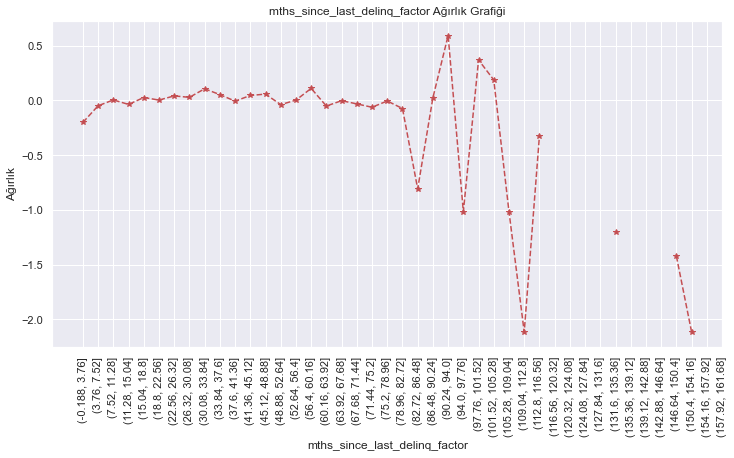

In [121]:
agirlik_plot(df_temp, 90)

In [122]:
# Boş, 0-3, 4-30, 31-56, >=57
X_train['mths_since_last_delinq:Missing'] = np.where((X_train['mths_since_last_delinq'].isnull()), 1, 0)
X_train['mths_since_last_delinq:0-3'] = np.where((X_train['mths_since_last_delinq'] >= 0) & (X_train['mths_since_last_delinq'] <= 3), 1, 0)
X_train['mths_since_last_delinq:4-30'] = np.where((X_train['mths_since_last_delinq'] >= 4) & (X_train['mths_since_last_delinq'] <= 30), 1, 0)
X_train['mths_since_last_delinq:31-56'] = np.where((X_train['mths_since_last_delinq'] >= 31) & (X_train['mths_since_last_delinq'] <= 56), 1, 0)
X_train['mths_since_last_delinq:>=57'] = np.where((X_train['mths_since_last_delinq'] >= 57), 1, 0)

<ipython-input-122-d364bd105c85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_last_delinq:Missing'] = np.where((X_train['mths_since_last_delinq'].isnull()), 1, 0)
<ipython-input-122-d364bd105c85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_last_delinq:0-3'] = np.where((X_train['mths_since_last_delinq'] >= 0) & (X_train['mths_since_last_delinq'] <= 3), 1, 0)
<ipython-input-122-d364bd105c85>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

### dti 

In [123]:
X_train['dti_factor'] = pd.cut(X_train['dti'], 100)
df_temp = iv_cal_con(X_train, 'dti_factor', y_train)
df_temp

<ipython-input-123-f402edbe067a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['dti_factor'] = pd.cut(X_train['dti'], 100)


,dti_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(-0.04, 0.4]",745,0.876510,0.001997,653.0,92.0,0.001965,0.002256,-0.137956,NaN,NaN,0.028446
1,"(0.4, 0.8]",808,0.919554,0.002166,743.0,65.0,0.002236,0.001594,0.338564,4.304439e-02,4.765202e-01,0.028446
2,"(0.8, 1.2]",922,0.896963,0.002472,827.0,95.0,0.002489,0.002330,0.066183,2.259133e-02,2.723810e-01,0.028446
3,"(1.2, 1.6]",1043,0.896453,0.002796,935.0,108.0,0.002814,0.002648,0.060670,5.105829e-04,5.512501e-03,0.028446
4,"(1.6, 2.0]",1172,0.902730,0.003142,1058.0,114.0,0.003184,0.002796,0.130192,6.277835e-03,6.952186e-02,0.028446
5,"(2.0, 2.399]",1337,0.916978,0.003584,1226.0,111.0,0.003690,0.002722,0.304237,1.424793e-02,1.740448e-01,0.028446
6,"(2.399, 2.799]",1538,0.916125,0.004123,1409.0,129.0,0.004241,0.003163,0.293078,8.534722e-04,1.115881e-02,0.028446
7,"(2.799, 3.199]",1696,0.904481,0.004547,1534.0,162.0,0.004617,0.003973,0.150293,1.164371e-02,1.427855e-01,0.028446
8,"(3.199, 3.599]",1927,0.900363,0.005166,1735.0,192.0,0.005222,0.004708,0.103522,4.117873e-03,4.677033e-02,0.028446
9,"(3.599, 3.999]",2197,0.914429,0.005890,2009.0,188.0,0.006047,0.004610,0.271205,1.406551e-02,1.676831e-01,0.028446


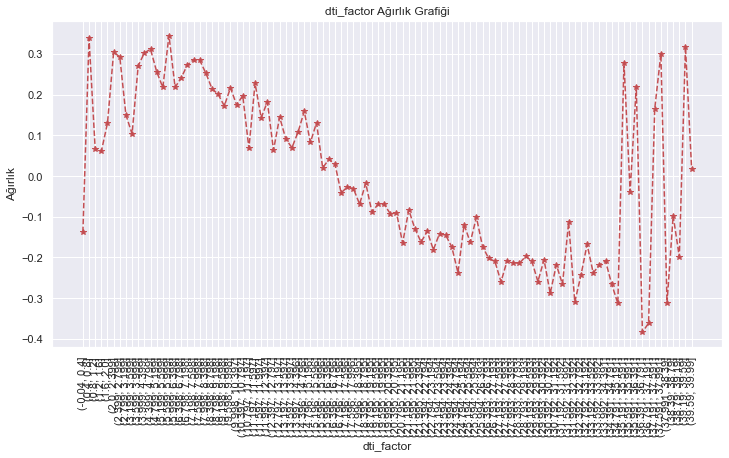

In [124]:
agirlik_plot(df_temp, 90)

In [125]:
# aynı yıllık gelir gibi incelemek gerekiyor
X_train_temp = X_train.loc[X_train['dti'] <= 35, : ]

In [126]:
X_train_temp['dti_factor'] = pd.cut(X_train_temp['dti'], 50)
df_temp = iv_cal_con(X_train_temp, 'dti_factor', y_train[X_train_temp.index])
df_temp

<ipython-input-126-cd4dcd61d985>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_temp['dti_factor'] = pd.cut(X_train_temp['dti'], 50)


,dti_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(-0.035, 0.7]",1366,0.894583,0.003690,1222.0,144.0,0.003707,0.003560,0.040465,NaN,NaN,0.027289
1,"(0.7, 1.4]",1664,0.893029,0.004496,1486.0,178.0,0.004507,0.004400,0.024094,0.001554,0.016371,0.027289
2,"(1.4, 2.1]",1986,0.912890,0.005365,1813.0,173.0,0.005499,0.004276,0.251481,0.019861,0.227387,0.027289
3,"(2.1, 2.8]",2594,0.913261,0.007008,2369.0,225.0,0.007186,0.005562,0.256157,0.000371,0.004676,0.027289
4,"(2.8, 3.5]",3135,0.903030,0.008470,2831.0,304.0,0.008587,0.007515,0.133392,0.010231,0.122765,0.027289
5,"(3.5, 4.2]",3844,0.915713,0.010385,3520.0,324.0,0.010677,0.008009,0.287507,0.012682,0.154115,0.027289
6,"(4.2, 4.9]",4595,0.914037,0.012414,4200.0,395.0,0.012739,0.009764,0.265988,0.001676,0.021519,0.027289
7,"(4.9, 5.6]",5312,0.912651,0.014351,4848.0,464.0,0.014705,0.011470,0.248471,0.001386,0.017517,0.027289
8,"(5.6, 6.3]",5927,0.914797,0.016013,5422.0,505.0,0.016446,0.012483,0.275696,0.002146,0.027225,0.027289
9,"(6.3, 7.0]",6482,0.911601,0.017512,5909.0,573.0,0.017923,0.014164,0.235381,0.003195,0.040315,0.027289


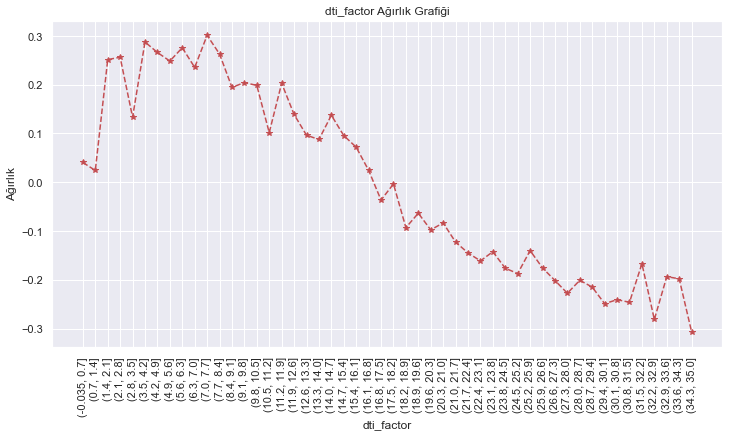

In [127]:
agirlik_plot(df_temp, 90)

In [128]:
X_train['dti:<=1.4'] = np.where((X_train['dti'] <= 1.4), 1, 0)
X_train['dti:1.4-3.5'] = np.where((X_train['dti'] > 1.4) & (X_train['dti'] <= 3.5), 1, 0)
X_train['dti:3.5-7.7'] = np.where((X_train['dti'] > 3.5) & (X_train['dti'] <= 7.7), 1, 0)
X_train['dti:7.7-10.5'] = np.where((X_train['dti'] > 7.7) & (X_train['dti'] <= 10.5), 1, 0)
X_train['dti:10.5-16.1'] = np.where((X_train['dti'] > 10.5) & (X_train['dti'] <= 16.1), 1, 0)
X_train['dti:16.1-20.3'] = np.where((X_train['dti'] > 16.1) & (X_train['dti'] <= 20.3), 1, 0)
X_train['dti:20.3-21.7'] = np.where((X_train['dti'] > 20.3) & (X_train['dti'] <= 21.7), 1, 0)
X_train['dti:21.7-22.4'] = np.where((X_train['dti'] > 21.7) & (X_train['dti'] <= 22.4), 1, 0)
X_train['dti:22.4-35'] = np.where((X_train['dti'] > 22.4) & (X_train['dti'] <= 35), 1, 0)
X_train['dti:>35'] = np.where((X_train['dti'] > 35), 1, 0)

<ipython-input-128-6d764556a0ad>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['dti:<=1.4'] = np.where((X_train['dti'] <= 1.4), 1, 0)
<ipython-input-128-6d764556a0ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['dti:1.4-3.5'] = np.where((X_train['dti'] > 1.4) & (X_train['dti'] <= 3.5), 1, 0)
<ipython-input-128-6d764556a0ad>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### mths_since_last_record 

In [129]:
X_train_temp = X_train[pd.notnull(X_train['mths_since_last_record'])]
X_train_temp['mths_since_last_record_factor'] = pd.cut(X_train_temp['mths_since_last_record'], 50)
df_temp = iv_cal_con(X_train_temp, 'mths_since_last_record_factor', y_train[X_train_temp.index])
df_temp

<ipython-input-129-8dbada21a70f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_temp['mths_since_last_record_factor'] = pd.cut(X_train_temp['mths_since_last_record'], 50)


,mths_since_last_record_factor,n_obs,prop_1,prop_n_obs,n_1,n_0,prop_n_1,prop_n_0,Agirlik,diff_prop_1,diff_Agirlik,IV
0,"(-0.121, 2.42]",1086,0.764273,0.021691,830.0,256.0,0.018569,0.047672,-0.942830,NaN,NaN,0.080659
1,"(2.42, 4.84]",76,0.894737,0.001518,68.0,8.0,0.001521,0.001490,0.020988,0.130464,0.963818,0.080659
2,"(4.84, 7.26]",163,0.914110,0.003256,149.0,14.0,0.003334,0.002607,0.245810,0.019374,0.224823,0.080659
3,"(7.26, 9.68]",156,0.903846,0.003116,141.0,15.0,0.003155,0.002793,0.121631,0.010264,0.124179,0.080659
4,"(9.68, 12.1]",292,0.907534,0.005832,265.0,27.0,0.005929,0.005028,0.164814,0.003688,0.043183,0.080659
5,"(12.1, 14.52]",207,0.917874,0.004134,190.0,17.0,0.004251,0.003166,0.294732,0.010340,0.129918,0.080659
6,"(14.52, 16.94]",210,0.928571,0.004194,195.0,15.0,0.004363,0.002793,0.445871,0.010697,0.151139,0.080659
7,"(16.94, 19.36]",334,0.907186,0.006671,303.0,31.0,0.006779,0.005773,0.160667,0.021386,0.285204,0.080659
8,"(19.36, 21.78]",283,0.936396,0.005652,265.0,18.0,0.005929,0.003352,0.570280,0.029210,0.409612,0.080659
9,"(21.78, 24.2]",455,0.898901,0.009088,409.0,46.0,0.009151,0.008566,0.065995,0.037495,0.504284,0.080659


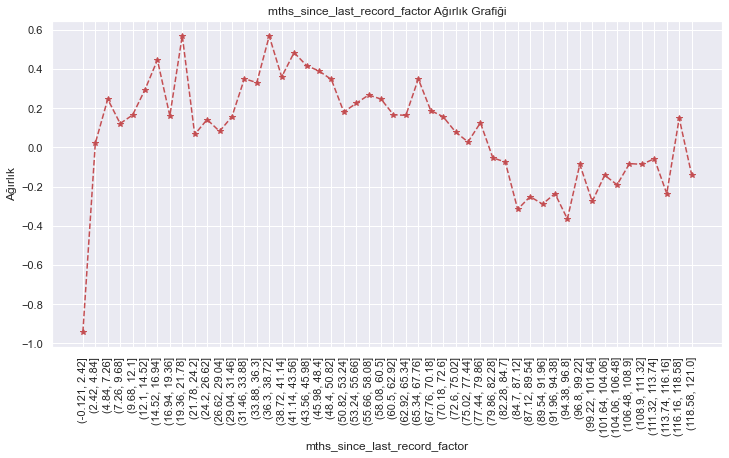

In [130]:
agirlik_plot(df_temp, 90)

In [131]:
# Boş, '0-2', '3-20', '21-31', '32-80', '81-86', '>86'
X_train['mths_since_last_record:Missing'] = np.where((X_train['mths_since_last_record'].isnull()), 1, 0)
X_train['mths_since_last_record:0-2'] = np.where((X_train['mths_since_last_record'] >= 0) & (X_train['mths_since_last_record'] <= 2), 1, 0)
X_train['mths_since_last_record:3-20'] = np.where((X_train['mths_since_last_record'] >= 3) & (X_train['mths_since_last_record'] <= 20), 1, 0)
X_train['mths_since_last_record:21-31'] = np.where((X_train['mths_since_last_record'] >= 21) & (X_train['mths_since_last_record'] <= 31), 1, 0)
X_train['mths_since_last_record:32-80'] = np.where((X_train['mths_since_last_record'] >= 32) & (X_train['mths_since_last_record'] <= 80), 1, 0)
X_train['mths_since_last_record:81-86'] = np.where((X_train['mths_since_last_record'] >= 81) & (X_train['mths_since_last_record'] <= 86), 1, 0)
X_train['mths_since_last_record:>86'] = np.where((X_train['mths_since_last_record'] > 86), 1, 0)

<ipython-input-131-e7c12245d23d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_last_record:Missing'] = np.where((X_train['mths_since_last_record'].isnull()), 1, 0)
<ipython-input-131-e7c12245d23d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['mths_since_last_record:0-2'] = np.where((X_train['mths_since_last_record'] >= 0) & (X_train['mths_since_last_record'] <= 2), 1, 0)
<ipython-input-131-e7c12245d23d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

# Train set üzerinde yaptığım her değişikliği Test seti üzerinde uyguluyorum

In [132]:
#home_ownership
X_test['home_ownership:RENT_OTHER_NONE_ANY'] = sum([X_test['home_ownership:RENT'], X_test['home_ownership:OTHER'],
                                                      X_test['home_ownership:NONE'],X_test['home_ownership:ANY']])


#addr_state
X_test['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_test['addr_state:NE'],
                                              X_test['addr_state:IA'], X_test['addr_state:NV'],
                                              X_test['addr_state:FL'], X_test['addr_state:HI'],
                                                          X_test['addr_state:AL']])

X_test['addr_state:NM_VA'] = sum([X_test['addr_state:NM'], X_test['addr_state:VA']])

X_test['addr_state:OK_TN_MO_LA_MD_NC'] = sum([X_test['addr_state:OK'], X_test['addr_state:TN'],
                                              X_test['addr_state:MO'], X_test['addr_state:LA'],
                                              X_test['addr_state:MD'], X_test['addr_state:NC']])

X_test['addr_state:UT_KY_AZ_NJ'] = sum([X_test['addr_state:UT'], X_test['addr_state:KY'],
                                              X_test['addr_state:AZ'], X_test['addr_state:NJ']])

X_test['addr_state:AR_MI_PA_OH_MN'] = sum([X_test['addr_state:AR'], X_test['addr_state:MI'],
                                              X_test['addr_state:PA'], X_test['addr_state:OH'],
                                              X_test['addr_state:MN']])

X_test['addr_state:RI_MA_DE_SD_IN'] = sum([X_test['addr_state:RI'], X_test['addr_state:MA'],
                                              X_test['addr_state:DE'], X_test['addr_state:SD'],
                                              X_test['addr_state:IN']])

X_test['addr_state:GA_WA_OR'] = sum([X_test['addr_state:GA'], X_test['addr_state:WA'],
                                              X_test['addr_state:OR']])

X_test['addr_state:WI_MT'] = sum([X_test['addr_state:WI'], X_test['addr_state:MT']])

X_test['addr_state:IL_CT'] = sum([X_test['addr_state:IL'], X_test['addr_state:CT']])

X_test['addr_state:KS_SC_CO_VT_AK_MS'] = sum([X_test['addr_state:KS'], X_test['addr_state:SC'],
                                              X_test['addr_state:CO'], X_test['addr_state:VT'],
                                              X_test['addr_state:AK'], X_test['addr_state:MS']])

X_test['addr_state:WV_NH_WY_DC_ME_ID'] = sum([X_test['addr_state:WV'], X_test['addr_state:NH'],
                                              X_test['addr_state:WY'], X_test['addr_state:DC'],
                                              X_test['addr_state:ME'], X_test['addr_state:ID']])




#purpose
X_test['purpose:educ__sm_b__wedd__ren_en__mov__house'] = sum([X_test['purpose:educational'], X_test['purpose:small_business'],
                                                                 X_test['purpose:wedding'], X_test['purpose:renewable_energy'],
                                                                 X_test['purpose:moving'], X_test['purpose:house']])
X_test['purpose:oth__med__vacation'] = sum([X_test['purpose:other'], X_test['purpose:medical'],
                                             X_test['purpose:vacation']])
X_test['purpose:major_purch__car__home_impr'] = sum([X_test['purpose:major_purchase'], X_test['purpose:car'],
                                                        X_test['purpose:home_improvement']])



#term
X_test['term:36'] = np.where((X_test['term_int'] == 36), 1, 0)
X_test['term:60'] = np.where((X_test['term_int'] == 60), 1, 0)



#emp_lenght
X_test['emp_length:0'] = np.where(X_test['emp_length_int'].isin([0]), 1, 0)
X_test['emp_length:1'] = np.where(X_test['emp_length_int'].isin([1]), 1, 0)
X_test['emp_length:2-4'] = np.where(X_test['emp_length_int'].isin(range(2, 5)), 1, 0)
X_test['emp_length:5-6'] = np.where(X_test['emp_length_int'].isin(range(5, 7)), 1, 0)
X_test['emp_length:7-9'] = np.where(X_test['emp_length_int'].isin(range(7, 10)), 1, 0)
X_test['emp_length:10'] = np.where(X_test['emp_length_int'].isin([10]), 1, 0)



#mths_since_issue_d
X_test['mths_since_issue_d:<70'] = np.where(X_test['mths_since_issue_d'].isin(range(70)), 1, 0)
X_test['mths_since_issue_d:70-71'] = np.where(X_test['mths_since_issue_d'].isin(range(70, 72)), 1, 0)
X_test['mths_since_issue_d:72-73'] = np.where(X_test['mths_since_issue_d'].isin(range(72, 74)), 1, 0)
X_test['mths_since_issue_d:74-80'] = np.where(X_test['mths_since_issue_d'].isin(range(74, 81)), 1, 0)
X_test['mths_since_issue_d:81-84'] = np.where(X_test['mths_since_issue_d'].isin(range(81, 85)), 1, 0)
X_test['mths_since_issue_d:85-96'] = np.where(X_test['mths_since_issue_d'].isin(range(85, 97)), 1, 0)
X_test['mths_since_issue_d:97-116'] = np.where(X_test['mths_since_issue_d'].isin(range(97, 117)), 1, 0)
X_test['mths_since_issue_d:>116'] = np.where(X_test['mths_since_issue_d'].isin(range(117, int(X_test['mths_since_issue_d'].max()))), 1, 0)




#int_rate
X_test['int_rate:<9.548'] = np.where((X_test['int_rate'] <= 9.548), 1, 0)
X_test['int_rate:9.548-12.025'] = np.where((X_test['int_rate'] > 9.548) & (X_test['int_rate'] <= 12.025), 1, 0)
X_test['int_rate:12.025-15.74'] = np.where((X_test['int_rate'] > 12.025) & (X_test['int_rate'] <= 15.74), 1, 0)
X_test['int_rate:15.74-20.281'] = np.where((X_test['int_rate'] > 15.74) & (X_test['int_rate'] <= 20.281), 1, 0)
X_test['int_rate:>20.281'] = np.where((X_test['int_rate'] > 20.281), 1, 0)




#mths_since_earliest_cr_line
X_test['mths_since_earliest_cr_line:<140'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
X_test['mths_since_earliest_cr_line:141-164'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
X_test['mths_since_earliest_cr_line:165-247'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(165, 248)), 1, 0)
X_test['mths_since_earliest_cr_line:248-270'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(248, 271)), 1, 0)
X_test['mths_since_earliest_cr_line:271-352'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(271, 353)), 1, 0)
X_test['mths_since_earliest_cr_line:>352'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(353, int(X_test['mths_since_earliest_cr_line'].max()))), 1, 0)





#delinq_2yrs
X_test['delinq_2yrs:0'] = np.where((X_test['delinq_2yrs'] == 0), 1, 0)
X_test['delinq_2yrs:1-3'] = np.where((X_test['delinq_2yrs'] >= 1) & (X_test['delinq_2yrs'] <= 3), 1, 0)
X_test['delinq_2yrs:>=4'] = np.where((X_test['delinq_2yrs'] >= 9), 1, 0)




#inq_last_6mths
X_test['inq_last_6mths:0'] = np.where((X_test['inq_last_6mths'] == 0), 1, 0)
X_test['inq_last_6mths:1-2'] = np.where((X_test['inq_last_6mths'] >= 1) & (X_test['inq_last_6mths'] <= 2), 1, 0)
X_test['inq_last_6mths:3-6'] = np.where((X_test['inq_last_6mths'] >= 3) & (X_test['inq_last_6mths'] <= 6), 1, 0)
X_test['inq_last_6mths:>6'] = np.where((X_test['inq_last_6mths'] > 6), 1, 0)



#open_acc
X_test['open_acc:0'] = np.where((X_test['open_acc'] == 0), 1, 0)
X_test['open_acc:1-3'] = np.where((X_test['open_acc'] >= 1) & (X_test['open_acc'] <= 3), 1, 0)
X_test['open_acc:4-12'] = np.where((X_test['open_acc'] >= 4) & (X_test['open_acc'] <= 12), 1, 0)
X_test['open_acc:13-17'] = np.where((X_test['open_acc'] >= 13) & (X_test['open_acc'] <= 17), 1, 0)
X_test['open_acc:18-22'] = np.where((X_test['open_acc'] >= 18) & (X_test['open_acc'] <= 22), 1, 0)
X_test['open_acc:23-25'] = np.where((X_test['open_acc'] >= 23) & (X_test['open_acc'] <= 25), 1, 0)
X_test['open_acc:26-30'] = np.where((X_test['open_acc'] >= 26) & (X_test['open_acc'] <= 30), 1, 0)
X_test['open_acc:>=31'] = np.where((X_test['open_acc'] >= 31), 1, 0)



#pub_rec
X_test['pub_rec:0-2'] = np.where((X_test['pub_rec'] >= 0) & (X_test['pub_rec'] <= 2), 1, 0)
X_test['pub_rec:3-4'] = np.where((X_test['pub_rec'] >= 3) & (X_test['pub_rec'] <= 4), 1, 0)
X_test['pub_rec:>=5'] = np.where((X_test['pub_rec'] >= 5), 1, 0)



#total_acc
X_test['total_acc:<=27'] = np.where((X_test['total_acc'] <= 27), 1, 0)
X_test['total_acc:28-51'] = np.where((X_test['total_acc'] >= 28) & (X_test['total_acc'] <= 51), 1, 0)
X_test['total_acc:>=52'] = np.where((X_test['total_acc'] >= 52), 1, 0)



#acc_now_delinq
X_test['acc_now_delinq:0'] = np.where((X_test['acc_now_delinq'] == 0), 1, 0)
X_test['acc_now_delinq:>=1'] = np.where((X_test['acc_now_delinq'] >= 1), 1, 0)



#total_rev_hi_lim
X_test['total_rev_hi_lim:<=5K'] = np.where((X_test['total_rev_hi_lim'] <= 5000), 1, 0)
X_test['total_rev_hi_lim:5K-10K'] = np.where((X_test['total_rev_hi_lim'] > 5000) & (X_test['total_rev_hi_lim'] <= 10000), 1, 0)
X_test['total_rev_hi_lim:10K-20K'] = np.where((X_test['total_rev_hi_lim'] > 10000) & (X_test['total_rev_hi_lim'] <= 20000), 1, 0)
X_test['total_rev_hi_lim:20K-30K'] = np.where((X_test['total_rev_hi_lim'] > 20000) & (X_test['total_rev_hi_lim'] <= 30000), 1, 0)
X_test['total_rev_hi_lim:30K-40K'] = np.where((X_test['total_rev_hi_lim'] > 30000) & (X_test['total_rev_hi_lim'] <= 40000), 1, 0)
X_test['total_rev_hi_lim:40K-55K'] = np.where((X_test['total_rev_hi_lim'] > 40000) & (X_test['total_rev_hi_lim'] <= 55000), 1, 0)
X_test['total_rev_hi_lim:55K-95K'] = np.where((X_test['total_rev_hi_lim'] > 55000) & (X_test['total_rev_hi_lim'] <= 95000), 1, 0)
X_test['total_rev_hi_lim:>95K'] = np.where((X_test['total_rev_hi_lim'] > 95000), 1, 0)




#installment
X_test['installment_factor'] = pd.cut(X_test['installment'], 50)


#annual income
X_test['annual_inc:<20K'] = np.where((X_test['annual_inc'] <= 20000), 1, 0)
X_test['annual_inc:20K-30K'] = np.where((X_test['annual_inc'] > 20000) & (X_test['annual_inc'] <= 30000), 1, 0)
X_test['annual_inc:30K-40K'] = np.where((X_test['annual_inc'] > 30000) & (X_test['annual_inc'] <= 40000), 1, 0)
X_test['annual_inc:40K-50K'] = np.where((X_test['annual_inc'] > 40000) & (X_test['annual_inc'] <= 50000), 1, 0)
X_test['annual_inc:50K-60K'] = np.where((X_test['annual_inc'] > 50000) & (X_test['annual_inc'] <= 60000), 1, 0)
X_test['annual_inc:60K-70K'] = np.where((X_test['annual_inc'] > 60000) & (X_test['annual_inc'] <= 70000), 1, 0)
X_test['annual_inc:70K-80K'] = np.where((X_test['annual_inc'] > 70000) & (X_test['annual_inc'] <= 80000), 1, 0)
X_test['annual_inc:80K-90K'] = np.where((X_test['annual_inc'] > 80000) & (X_test['annual_inc'] <= 90000), 1, 0)
X_test['annual_inc:90K-100K'] = np.where((X_test['annual_inc'] > 90000) & (X_test['annual_inc'] <= 100000), 1, 0)
X_test['annual_inc:100K-120K'] = np.where((X_test['annual_inc'] > 100000) & (X_test['annual_inc'] <= 120000), 1, 0)
X_test['annual_inc:120K-140K'] = np.where((X_test['annual_inc'] > 120000) & (X_test['annual_inc'] <= 140000), 1, 0)
X_test['annual_inc:>140K'] = np.where((X_test['annual_inc'] > 140000), 1, 0)



# mths_since_last_delinq
X_test['mths_since_last_delinq:Missing'] = np.where((X_test['mths_since_last_delinq'].isnull()), 1, 0)
X_test['mths_since_last_delinq:0-3'] = np.where((X_test['mths_since_last_delinq'] >= 0) & (X_test['mths_since_last_delinq'] <= 3), 1, 0)
X_test['mths_since_last_delinq:4-30'] = np.where((X_test['mths_since_last_delinq'] >= 4) & (X_test['mths_since_last_delinq'] <= 30), 1, 0)
X_test['mths_since_last_delinq:31-56'] = np.where((X_test['mths_since_last_delinq'] >= 31) & (X_test['mths_since_last_delinq'] <= 56), 1, 0)
X_test['mths_since_last_delinq:>=57'] = np.where((X_test['mths_since_last_delinq'] >= 57), 1, 0)


#dti
X_test['dti:<=1.4'] = np.where((X_test['dti'] <= 1.4), 1, 0)
X_test['dti:1.4-3.5'] = np.where((X_test['dti'] > 1.4) & (X_test['dti'] <= 3.5), 1, 0)
X_test['dti:3.5-7.7'] = np.where((X_test['dti'] > 3.5) & (X_test['dti'] <= 7.7), 1, 0)
X_test['dti:7.7-10.5'] = np.where((X_test['dti'] > 7.7) & (X_test['dti'] <= 10.5), 1, 0)
X_test['dti:10.5-16.1'] = np.where((X_test['dti'] > 10.5) & (X_test['dti'] <= 16.1), 1, 0)
X_test['dti:16.1-20.3'] = np.where((X_test['dti'] > 16.1) & (X_test['dti'] <= 20.3), 1, 0)
X_test['dti:20.3-21.7'] = np.where((X_test['dti'] > 20.3) & (X_test['dti'] <= 21.7), 1, 0)
X_test['dti:21.7-22.4'] = np.where((X_test['dti'] > 21.7) & (X_test['dti'] <= 22.4), 1, 0)
X_test['dti:22.4-35'] = np.where((X_test['dti'] > 22.4) & (X_test['dti'] <= 35), 1, 0)
X_test['dti:>35'] = np.where((X_test['dti'] > 35), 1, 0)



#mths_since_last_record
X_test['mths_since_last_record:Missing'] = np.where((X_test['mths_since_last_record'].isnull()), 1, 0)
X_test['mths_since_last_record:0-2'] = np.where((X_test['mths_since_last_record'] >= 0) & (X_test['mths_since_last_record'] <= 2), 1, 0)
X_test['mths_since_last_record:3-20'] = np.where((X_test['mths_since_last_record'] >= 3) & (X_test['mths_since_last_record'] <= 20), 1, 0)
X_test['mths_since_last_record:21-31'] = np.where((X_test['mths_since_last_record'] >= 21) & (X_test['mths_since_last_record'] <= 31), 1, 0)
X_test['mths_since_last_record:32-80'] = np.where((X_test['mths_since_last_record'] >= 32) & (X_test['mths_since_last_record'] <= 80), 1, 0)
X_test['mths_since_last_record:81-86'] = np.where((X_test['mths_since_last_record'] >= 81) & (X_test['mths_since_last_record'] <= 86), 1, 0)
X_test['mths_since_last_record:>86'] = np.where((X_test['mths_since_last_record'] > 86), 1, 0)

<ipython-input-132-1bde8625be7e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['home_ownership:RENT_OTHER_NONE_ANY'] = sum([X_test['home_ownership:RENT'], X_test['home_ownership:OTHER'],
<ipython-input-132-1bde8625be7e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['addr_state:ND_NE_IA_NV_FL_HI_AL'] = sum([X_test['addr_state:NE'],
<ipython-input-132-1bde8625be7e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

<ipython-input-132-1bde8625be7e>:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['mths_since_earliest_cr_line:<140'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(140)), 1, 0)
<ipython-input-132-1bde8625be7e>:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['mths_since_earliest_cr_line:141-164'] = np.where(X_test['mths_since_earliest_cr_line'].isin(range(140, 165)), 1, 0)
<ipython-input-132-1bde8625be7e>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

<ipython-input-132-1bde8625be7e>:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['dti:10.5-16.1'] = np.where((X_test['dti'] > 10.5) & (X_test['dti'] <= 16.1), 1, 0)
<ipython-input-132-1bde8625be7e>:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['dti:16.1-20.3'] = np.where((X_test['dti'] > 16.1) & (X_test['dti'] <= 20.3), 1, 0)
<ipython-input-132-1bde8625be7e>:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

# Train ve test datalarını csv olarak kaydettim

Çünkü her seferinde veri hazırlığı kısmını çağırmak istemiyorum

In [133]:
X_train.to_csv('X_train.csv')
y_train.to_csv('y_train.csv')
X_test.to_csv('X_test.csv')
y_test.to_csv('y_test.csv')